In [58]:
import numpy as np
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Viz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# Remove this later
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [74]:
df1=pd.read_csv("df_final.csv")
df1.head(2)

Missing_source_Month1  segment_ios_source_Month1  segment_tre_source_Month1  Missing_source_Month2  segment_ios_source_Month2  segment_tre_source_Month2  Missing_source_Week1  segment_ios_source_Week1  segment_tre_source_Week1  Missing_source_Week2  segment_ios_source_Week2  segment_tre_source_Week2  Missing_source_Week3  segment_ios_source_Week3  segment_tre_source_Week3  Missing_source_Week4  segment_ios_source_Week4  segment_tre_source_Week4  Missing_source_Week5  segment_tre_source_Week5  Missing_source_Week6  segment_ios_source_Week6  segment_tre_source_Week6  Missing_source_Week7  segment_ios_source_Week7  segment_tre_source_Week7  segment_ios_source_Week8  Other_main_activity_Month1  closed_session_main_activity_Month1  completed_session_main_activity_Month1  identified_app_user_main_activity_Month1  interacted_with_media_main_activity_Month1  logged_daily_sleep_main_activity_Month1  logged_daily_weight_main_activity_Month1  logged_elevated_heart_rate_main_activity_Month1  \
0                  408.0                      135.0                        NaN                    NaN                        NaN                        NaN                 408.0                     135.0                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                       NaN                        58.0                                 14.0                                     6.0                                       2.0                                        41.0                                      NaN                                       NaN                                              NaN   
1                   42.0                       69.0                        NaN                    NaN                        NaN                        NaN                  42.0                      69.0                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                       NaN                        19.0                                  2.0                                     2.0                                       2.0                                         NaN                                      NaN                                       NaN                                              NaN   

   logged_in_main_activity_Month1  logged_steps_main_activity_Month1  opened_app_main_activity_Month1  started_session_main_activity_Month1  viewed_screen_main_activity_Month1  viewed_session_element_main_activity_Month1  main_activity_Month1_Total  Other_main_activity_Month2  completed_session_main_activity_Month2  identified_app_user_main_activity_Month2  logged_in_main_activity_Month2  opened_app_main_activity_Month2  received_error_main_activity_Month2  started_app_session_main_activity_Month2  viewed_screen_main_activity_Month2  viewed_session_element_main_activity_Month2  main_activity_Month2_Total  Other_main_activity_Week1  closed_session_main_activity_Week1  completed_session_main_activity_Week1  identified_app_user_main_activity_Week1  interacted_with_media_main_activity_Week1  logged_in_main_activity_Week1  opened_app_main_activity_Week1  pressed_next_main_activity_Week1  received_error_main_activity_Week1  started_app_session_main_activity_Week1  \
0                          

In [75]:
df1.columns[df1.isna().mean()>.4]

Index(['segment_ios_source_Month1', 'segment_tre_source_Month1', 'Missing_source_Month2', 'segment_ios_source_Month2', 'segment_tre_source_Month2', 'segment_ios_source_Week1', 'segment_tre_source_Week1', 'Missing_source_Week2', 'segment_ios_source_Week2', 'segment_tre_source_Week2',
       ...
       'logged_daily_mindfulness_main_activity_vs_activity_occurence_std_Week8', 'health-step-count_counts', 'userwise_total_activities', 'health-step-distance_Total.2', 'Other_health-step-count', 'apple_health-flights-climbed', 'health-flights-climbed_Total.2', 'health-step-distance_Total.3', '1_health-step-count', 'health-step-count_Total.3'], dtype='object', length=231)

In [76]:
df1.isna().sum().sum()

106675

### Delete this

In [77]:
# Removing any features that has more than 80% missing values
cols_2_drop = df1.columns[df1.isna().mean()>.4]
df1 = df1.drop(columns=cols_2_drop)
df1 = df1.fillna(0)
len(cols_2_drop)
df1.isna().sum().sum()

0

In [78]:
# df.isna().sum().plot(kind='bar')

In [79]:
df1.shape

(553, 95)

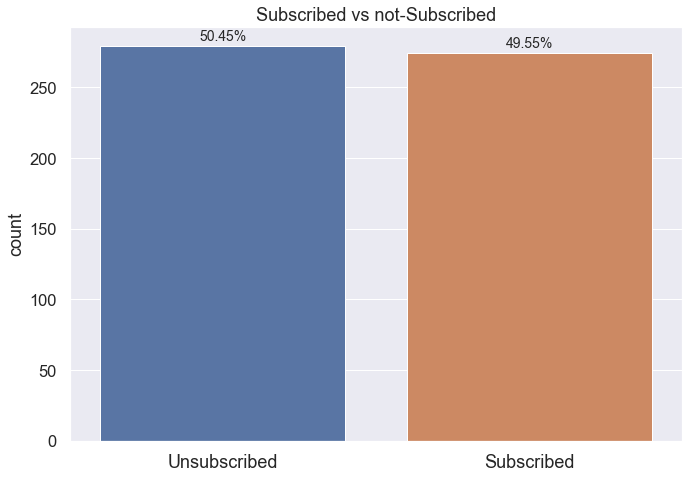

In [80]:
df1 = df1.fillna(0)
# function for countplot
def bplot_perc(col, data, title, xlabel, ax=None, hue=None):
    sns.set(font_scale=1.5)
    sns.countplot(col, data=data, ax=ax, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_xticklabels(['Unsubscribed','Subscribed'],size=18);
    total = len(data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + 4, '{:1.2f}%'.format((height/total)*100), ha="center", size=14) 
    plt.tight_layout()   
    plt.show()

# plot for target variable
f,ax=plt.subplots(1,1,figsize = (10,7))
bplot_perc(col='subscription', data=df1, title='Subscribed vs not-Subscribed', xlabel='', ax=ax)

**Balanced target, we will gave a better chance of making a robust model without upsampling.**

In [81]:
df1.shape

(553, 95)

In [82]:
len(df1.select_dtypes('O').columns)

2

In [83]:
print(f'No of categorical columns we need to encode:',len(df1.select_dtypes('O').columns))
# We dont need to encode 'owner' columns and subscription is our target
df2 = pd.get_dummies(df1.drop(columns=['owner', 'subscription']))
df2.shape

No of categorical columns we need to encode: 2


(553, 95)

**Both XGBoost and LightGBM works well**

In [84]:
df_log = pd.DataFrame()

for i in range(len(df2.columns)):
    df_log[df2.columns[i]] = np.log1p(df2[df2.columns[i]])

df_log.shape

(553, 95)

In [85]:
#df_log.describe()

In [86]:
df_log['subscription'] = df1['subscription']
df2['subscription'] = df1['subscription']
df_log['subscription'].value_counts()

0    279
1    274
Name: subscription, dtype: int64

In [87]:
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )  
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df_log,1,[df_log.columns])
df_log.loc[Outliers_to_drop]

Empty DataFrame
Columns: [Missing_source_Month1, Missing_source_Week1, Other_main_activity_Month1, identified_app_user_main_activity_Month1, logged_in_main_activity_Month1, logged_steps_main_activity_Month1, opened_app_main_activity_Month1, started_session_main_activity_Month1, viewed_screen_main_activity_Month1, main_activity_Month1_Total, Other_main_activity_Week1, identified_app_user_main_activity_Week1, logged_in_main_activity_Week1, opened_app_main_activity_Week1, received_error_main_activity_Week1, started_app_session_main_activity_Week1, started_session_main_activity_Week1, viewed_screen_main_activity_Week1, main_activity_Week1_Total, main_activity_Weekday_count_Total, main_activity_Weekday_count_Total.1, Feature1_1_count_nUnique, Other_feature_1_1_Month1, TRE_feature_1_1_Month1, error_feature_1_1_Month1, fitness-training_feature_1_1_Month1, viewed_screen_feature_1_1_Month1, Other_feature_1_1_Week1, TRE_feature_1_1_Week1, fitness-training_feature_1_1_Week1, feature_1_1_Week2_Total, Feature_2_nunique, df_feature_2_1_missing, Missing_feature_2_1_Month1, Missing_feature_2_1_Week1, Not-Misisng_feature_2_1_Week2, Feature_3_nunique, df_feature_3_1_missing, df_feature_3_1_notMissing, Missing_feature_3_1_Month1, Not-Misisng_feature_3_1_Month1, Missing_feature_3_1_Week1, Not-Misisng_feature_3_1_Week1, Other_main_activity_vs_activity_occurence_count, closed_session_main_activity_vs_activity_occurence_count, identified_app_user_main_activity_vs_activity_occurence_count, logged_in_main_activity_vs_activity_occurence_count, logged_steps_main_activity_vs_activity_occurence_count, opened_app_main_activity_vs_activity_occurence_count, received_error_main_activity_vs_activity_occurence_count, started_app_session_main_activity_vs_activity_occurence_count, started_session_main_activity_vs_activity_occurence_count, viewed_screen_main_activity_vs_activity_occurence_count, viewed_session_element_main_activity_vs_activity_occurence_count, Other_main_activity_vs_activity_occurence_sum, closed_session_main_activity_vs_activity_occurence_sum, identified_app_user_main_activity_vs_activity_occurence_sum, logged_in_main_activity_vs_activity_occurence_sum, logged_steps_main_activity_vs_activity_occurence_sum, opened_app_main_activity_vs_activity_occurence_sum, received_error_main_activity_vs_activity_occurence_sum, started_app_session_main_activity_vs_activity_occurence_sum, started_session_main_activity_vs_activity_occurence_sum, viewed_screen_main_activity_vs_activity_occurence_sum, viewed_session_element_main_activity_vs_activity_occurence_sum, Other_main_activity_vs_activity_occurence_std, viewed_screen_main_activity_vs_activity_occurence_std, Other_main_activity_vs_activity_occurence_sum_Month1, logged_in_main_activity_vs_activity_occurence_sum_Month1, opened_app_main_activity_vs_activity_occurence_sum_Month1, received_error_main_activity_vs_activity_occurence_sum_Month1, started_app_session_main_activity_vs_activity_occurence_sum_Month1, viewed_screen_main_activity_vs_activity_occurence_sum_Month1, main_activity_main_activity_vs_activity_occurence_sum_Month_Total1, Other_main_activity_vs_activity_occurence_std_Month1, logged_in_main_activity_vs_activity_occurence_std_Month1, viewed_screen_main_activity_vs_activity_occurence_std_Month1, main_activity_main_activity_vs_activity_occurence_std_Month_Total1, Other_main_activity_vs_activity_occurence_sum_Week1, identified_app_user_main_activity_vs_activity_occurence_sum_Week1, logged_in_main_activity_vs_activity_occurence_sum_Week1, opened_app_main_activity_vs_activity_occurence_sum_Week1, received_error_main_activity_vs_activity_occurence_sum_Week1, started_app_session_main_activity_vs_activity_occurence_sum_Week1, started_session_main_activity_vs_activity_occurence_sum_Week1, viewed_screen_main_activity_vs_activity_occurence_sum_Week1, Other_main_activity_vs_activity_occurence_std_Week1, logged_in_main_activity_vs_activity_occurence_std_Week1, viewed_screen_main_activity_vs_activity_occurence_std_W

In [88]:
# importing all the required ML packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#from sklearn import metrics 
from sklearn import metrics
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, make_scorer

In [89]:
# Models
logreg = LogisticRegression(random_state=0) 
randomforest = RandomForestClassifier(random_state=0, class_weight="balanced") 
gbk = GradientBoostingClassifier(random_state=0) 
xgb = XGBClassifier()
lgb = LGBMClassifier(boosting_type='gbdt',class_weight='balanced')

In [90]:
# Splititng data into train and test set
X = df_log.drop(columns=['subscription'])
# X1 = df2.drop(columns=['subscription'])
y = df2['subscription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

index = X_train.index
cols = X_train.columns
index1 = X_test.index
cols1 = X_test.columns
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=index, columns=cols)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, index=index1, columns=cols1)

In [91]:
# Model quality prediction
from termcolor import colored
model_names = ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']
models = [logreg,randomforest, gbk, xgb, lgb]

# original data
a_stdz = [X_train]
b_stdz = [y_train]
c_stdz = [X_test]
d_stdz = [y_test]

# SMOTE data
#a1_stdz = [X_train1]
#b1_stdz = [y_train1]
#c1_stdz = [X_test]
#d1_stdz = [y_test]

# function for model quality prediction
def model_quality(model):
    for i in range(len(a_stdz)):
        print('ORIGINAL DATA')
        model.fit(a_stdz[i], b_stdz[i])
        accuracy_model = round(model.score(c_stdz[i], d_stdz[i]) *100,2)
        print('accuracy :',accuracy_model, "\n")
        auc = roc_auc_score(d_stdz[i], model.predict(c_stdz[i]))
        print ("AUC = %2.2f" % auc)
        print (classification_report(d_stdz[i], model.predict(c_stdz[i])))
        
   # for i in range(len(a1_stdz)):
   #     print('='*66)
   #     print('SMOTE DATA')
   #     model.fit(a1_stdz[i], b1_stdz[i])
   #     accuracy_model = round(model.score(c1_stdz[i], d1_stdz[i]) *100,2)
   #     print('accuracy :',accuracy_model, "\n")
   #     auc = roc_auc_score(d1_stdz[i], model.predict(c1_stdz[i]))
   #     print ("AUC = %2.2f" % auc)
   #     print (classification_report(d1_stdz[i], model.predict(c1_stdz[i])))

for i in range(len(models)):
    print('■'*22, '\033[1m' + colored(model_names[i], 'green'), '■'*23)
    model_quality(models[i])
    print ("\n\n")

■■■■■■■■■■■■■■■■■■■■■■ LogisticRegression ■■■■■■■■■■■■■■■■■■■■■■■
ORIGINAL DATA
accuracy : 78.31 

AUC = 0.79
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        90
           1       0.73      0.83      0.78        76

    accuracy                           0.78       166
   macro avg       0.79      0.79      0.78       166
weighted avg       0.79      0.78      0.78       166




■■■■■■■■■■■■■■■■■■■■■■ RandomForest ■■■■■■■■■■■■■■■■■■■■■■■
ORIGINAL DATA
accuracy : 77.71 

AUC = 0.78
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        90
           1       0.75      0.78      0.76        76

    accuracy                           0.78       166
   macro avg       0.78      0.78      0.78       166
weighted avg       0.78      0.78      0.78       166




■■■■■■■■■■■■■■■■■■■■■■ GradientBoosting ■■■■■■■■■■■■■■■■■■■■■■■
ORIGINAL DATA
accuracy : 82.53 

AUC = 0.83
              prec

In [92]:
def cross_validation(X,y,scoring):
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0) 
    xyz=[] 
    accuracy_cv=[]
    classifiers=['LogisticRegression','RandomForest','GradientBoosting', 'XGBoost', 'LightGBM'] 
    models = [logreg,randomforest, gbk, xgb, lgb]
    for i in models:
        model = i
        cv_result = cross_val_score(model, X, y, cv=kfold, scoring = scoring)
        cv_result=cv_result
        xyz.append(cv_result.mean())
        accuracy_cv.append(cv_result)
    new_models_dataframe2 = pd.DataFrame({'CV Mean':xyz},index=classifiers) 
    new_models_dataframe2.loc['avg'] = new_models_dataframe2.mean()
    return new_models_dataframe2
    return accuracy_cv

cv_1 = cross_validation(X_train,y_train, scoring='precision')
cv_2 = cross_validation(X_train,y_train, scoring='recall')
cv_3 = cross_validation(X_train,y_train, scoring='roc_auc')

cv_comp = pd.concat([cv_1, cv_2, cv_3], axis=1)
cv_comp.columns = ['Precision_CV_mean', 'Recall_CV_mean', 'ROC-AUC_CV_mean']
cv_comp.sort_values(by='Precision_CV_mean', ascending=False)
cv_comp.loc['avg'] =cv_comp.mean()
cv_comp

Precision_CV_mean  Recall_CV_mean  ROC-AUC_CV_mean
LogisticRegression           0.729801        0.693634         0.798204
RandomForest                 0.815311        0.726123         0.879912
GradientBoosting             0.803038        0.761672         0.896797
XGBoost                      0.817108        0.808891         0.898793
LightGBM                     0.803862        0.787417         0.891747
avg                          0.793824        0.755547         0.873090

# Auto-optimization of hyper-parameters
from hyperopt import fmin, tpe, hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    
    if t == 'randomforest':
        clf = RandomForestClassifier(**params, random_state=0)

    if t == 'gradientboost':
        clf = GradientBoostingClassifier(**params, random_state=0) 
        
    if t == 'XGBboost':
        clf = GradientBoostingClassifier(**params, random_state=0) 
        
    if t == 'LightGBM':
        clf = LGBMClassifier(**params, random_state=0)
        
    else:
        return 0 
    
    return cross_val_score(clf, X_train, y_train, cv=kfold, scoring='f1', n_jobs=-1).mean()


space = hp.choice('classifier_type', [
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'min_samples_split': hp.choice('min_samples_split', range(2,10)),
        'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators', range(10,500,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    
        {
        'type': 'gradientboost',
        'max_depth': hp.choice('max_depth2', range(1,15)),
        'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators2', range(10,500,20)),
        "min_samples_split": hp.choice('min_samples_split2', range(2,15)),
        "min_samples_leaf": hp.choice('min_samples_leaf2', range(2,15)),
        'learning_rate': hp.choice('learning_rate', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
    },
    
        {
        'type': 'XGBboost',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'min_samples_split': hp.choice('min_samples_split', range(2,10)), # change this
        'min_samples_leaf': hp.choice('min_samples_leaf', range(2,10)),
        'max_features': hp.choice('max_features', ['auto','np.sqrt', 'np.log']),
        'subsample':hp.choice('subsample', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'n_estimators': hp.choice('n_estimators', range(10,500,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    
        {
        'type': 'LightGBM',
        'max_depth': hp.choice('max_depth2', range(1,15)),
        'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators2', range(10,500,20)),
        "min_samples_split": hp.choice('min_samples_split2', range(2,15)),
        'learning_rate': hp.choice('learning_rate', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
        'bagging_freq': hp.choice('bagging_freq', range(1,15)),
        'subsample_for_bin': hp.choice('subsample_for_bin', [200000, 300000, 400000]),
        'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'subsample':hp.choice('subsample2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
    },

])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print ('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        print('')
        print ('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=15000, trials=trials)
print ('best:')
print (best)

boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,

# Auto-optimization of hyper-parameters
from hyperopt import fmin, tpe, hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
#from sklearn.pipeline import Pipeline, make_pipeline
#from imblearn.pipeline import Pipeline, make_pipeline

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
#skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#X = 
#y = 
print (X.shape, y.shape)

def hyperopt_train_test(params):
    t = params['type']
    del params['type']

    if t == 'XGBboost':
        clf = XGBClassifier(**params, random_state=0)    
    if t == 'LightGBM':
        clf = LGBMClassifier(**params, random_state=0)
        
    else:
        return 0 

    return cross_val_score(clf, X, y, cv=kfold, scoring='f1', n_jobs=1).mean()


space = hp.choice('classifier_type', [
    {
        'type': 'XGBboost',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'min_samples_split': hp.choice('min_samples_split', range(2,10)), # change this
        #'min_samples_leaf': hp.choice('min_samples_leaf', range(1,10)),
        'max_features': hp.choice('max_features', ['auto','np.sqrt', 'np.log']),
        'subsample':hp.choice('subsample', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'n_estimators': hp.choice('n_estimators', range(10,500,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        #'scale': hp.choice('scale', [0, 1]),
        #'normalize': hp.choice('normalize', [0, 1])
    },
        {
        'type': 'LightGBM',
        'max_depth': hp.choice('max_depth2', range(1,15)),
        'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators2', range(10,500,20)),
        "min_samples_split": hp.choice('min_samples_split2', range(2,15)),
       # "min_samples_leaf": hp.choice('min_samples_leaf2', range(1,15)),
        'learning_rate': hp.choice('learning_rate', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
        'bagging_freq': hp.choice('bagging_freq', range(1,15)),
        'subsample_for_bin': hp.choice('subsample_for_bin', [200000, 300000, 400000]),
        'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'subsample':hp.choice('subsample2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        #'bagging_fraction':hp.choice('bagging_fraction', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
         #"criterion": hp.choice('criterion',["friedman_mse",  "mae"]),
        #'scale': hp.choice('scale', [0, 1]),
        #'normalize': hp.choice('normalize', [0, 1])
    },

])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print ('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        print('')
        print ('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=15000, trials=trials)
print ('best:')
print (best)

In [93]:
#LGBMClassifier(**params, random_state=0)

lgb = LGBMClassifier(random_state=0)

def tune(model, grid):
    #kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    gs = GridSearchCV(estimator=model, param_grid=grid, cv=kfold, n_jobs=10, verbose=1, scoring='f1')
    gs.fit(X_train, y_train) 
    print('Best score: ', gs.best_score_)
    print('Best params: ', gs.best_params_)
    #print('cv results: ', gs.cv_results_)
    print('Best estimator: ', gs.best_estimator_)


parameters = {
    #"loss":["deviance",'exponential'],
    #"learning_rate": [0.05, 0.1, 0.15, 0.2],                          #0.01, 0.025, 0.05, 0.075, , 0.075, 0.1, 0.15, 0.2, 0.5],
    #"min_samples_split": np.linspace(0.1, 0.5, 3),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[4,5,6],
    "max_features":['auto'],
   # "criterion": ["friedman_mse",  "mae"],
   # "subsample":[0.9, 0.95, 1.0],
    "n_estimators":range(10,40,5),
    "min_samples_split":[2,4,5],
    'learning_rate':[0.125, 0.15, 0.175],
    'loss':['deviance', 'exponential'],
    'bagging_freq':[8,9,10],
    'subsample_for_bin':[150000,200000,250000],
    'colsample_bytree':[0.8,0.85, 0.9],
    'subsample':[0.85, 0.9,0.95, 1]
    }

# 'type': 'LightGBM',
        #'max_depth': hp.choice('max_depth2', range(1,15)),
        #'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        #'n_estimators': hp.choice('n_estimators2', range(10,100,10)),
        # "min_samples_split": hp.choice('min_samples_split2', range(2,15)),
        # "min_samples_leaf": hp.choice('min_samples_leaf2', range(1,15)),
        #'learning_rate': hp.choice('learning_rate', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        #'loss': hp.choice('loss', ['deviance', 'exponential']),
        #'bagging_freq': hp.choice('bagging_freq', range(1,15)),
        #'subsample_for_bin': hp.choice('subsample_for_bin', [200000, 300000, 400000]),
        #'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        #'subsample':hp.choice('subsample2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),

tune(lgb, parameters)

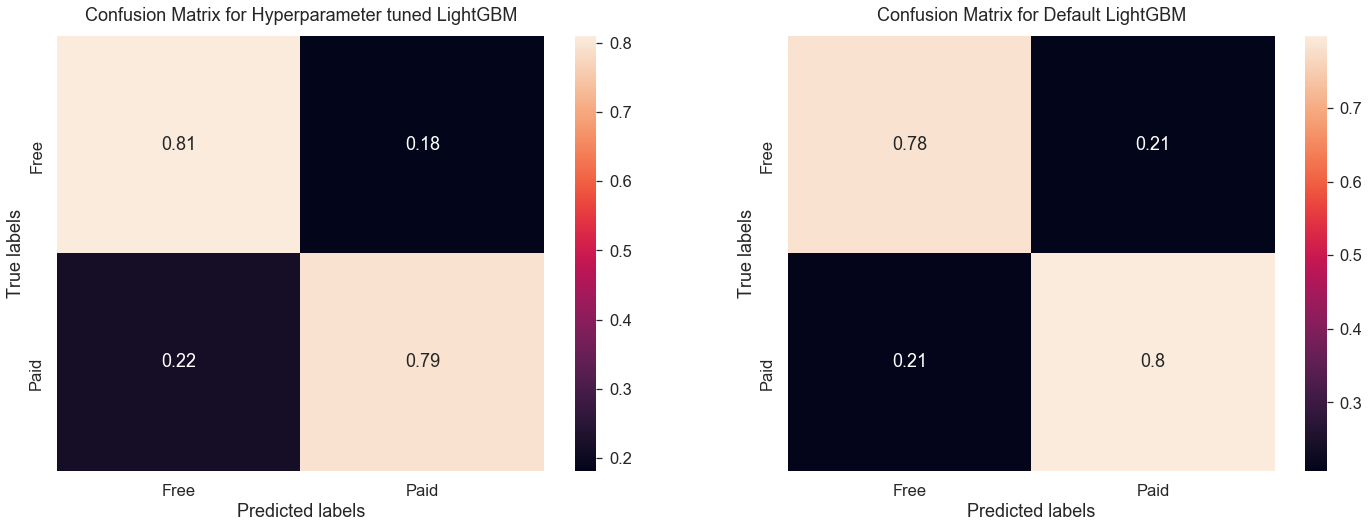

In [94]:
lgb_optimized = LGBMClassifier(bagging_freq=8,colsample_bytree=0.9,learning_rate=0.175, loss='deviance', max_depth=6,
                     max_features='auto',min_samples_split=2,n_estimators=35, n_jobs=-1,random_state=0,
                     subsample=0.9, subsample_for_bin=150000)
lgb_default = LGBMClassifier(random_state=0)

models = [lgb_optimized, lgb_default]
model_names = ['Hyperparameter tuned LightGBM', 'Default LightGBM']

from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        y_pred = cross_val_predict(models[i], X, y, cv=kfold)
        #labels = ['Free-Tier', 'Paid-Subscriber']
        C = confusion_matrix(y,y_pred)
        C = C / C.astype(np.float).sum(axis=1)
        sns.heatmap(C,ax=ax[i],annot=True)
        #confusion_matrix(y,y_pred)
        ax[i].set_title('Confusion Matrix for '+ model_names[i], pad=15) 
        # labels, title and ticks
        ax[i].set_xlabel('Predicted labels');ax[i].set_ylabel('True labels');  
        ax[i].xaxis.set_ticklabels(['Free', 'Paid']); ax[i].yaxis.set_ticklabels(['Free', 'Paid']);
        
fig, ax = plt.subplots(1,2,figsize=(24,8))
confusion_matrix_plot(X_train, y_train)

## ROC curve before after # Learning rate 

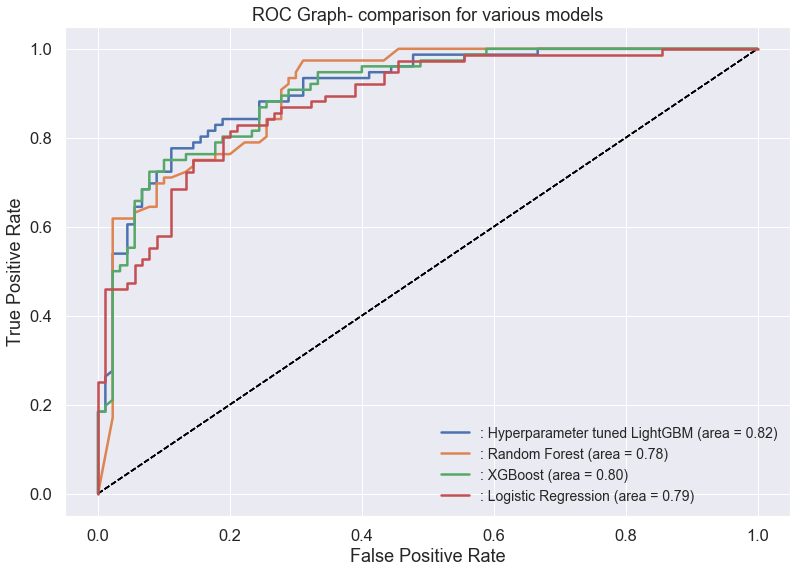

In [95]:
def auc_plots(models, a, b, c, d, label):
    for i in range(len(models)):
        models[i].fit(a, b)
        fpr, tpr, thresholds = roc_curve(d, models[i].predict_proba(c)[:,1])
        auc = roc_auc_score(d, models[i].predict(c))
        ax.set_title('ROC Graph- '+ label)
        plt.plot([0,1], [0,1], linestyle='--', color = 'black')
        ax.plot(fpr, tpr,linewidth=2.5,label='' + ': ' + str(model_names[i])+ ' (area = %0.2f)' % auc)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right", prop={'size': 14})
    return plt.show()

rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)
lr = LogisticRegression(random_state=0)
models = [lgb_optimized, rf, xgb, lr]
model_names = ['Hyperparameter tuned LightGBM', 'Random Forest', 'XGBoost', 'Logistic Regression']
f,ax=plt.subplots(figsize=(13,9))
auc_plots(models, X_train, y_train, X_test, y_test, label='comparison for various models')

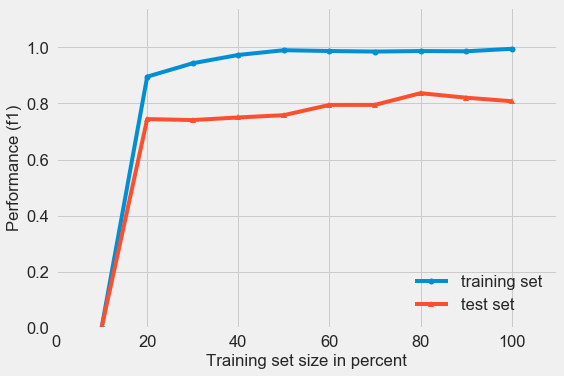

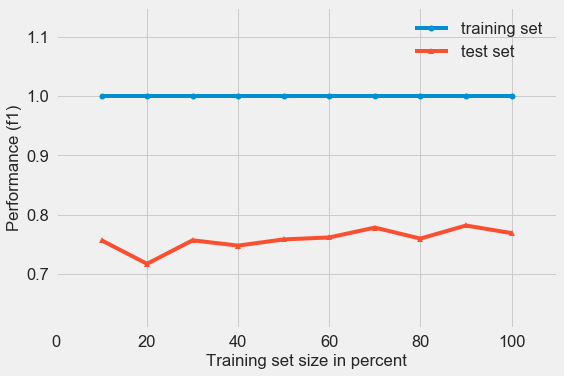

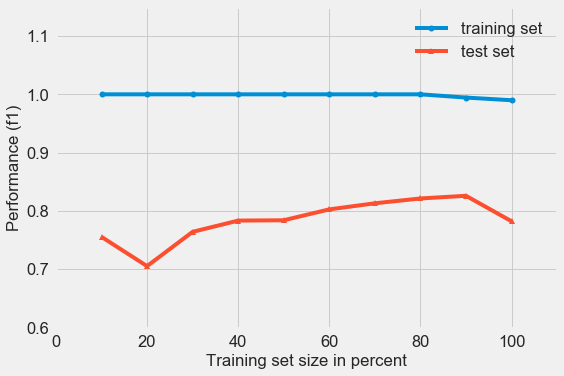

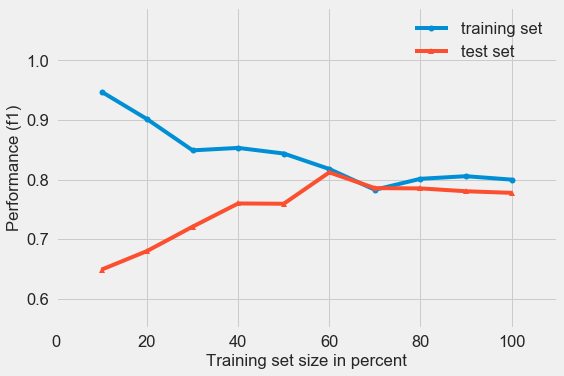

In [96]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
import numpy as np

clf = [lgb_optimized, rf, xgb, lr]
clf_name = ['LightGBM_optimized', 'XGBoost', 'RandomForest', 'LogisticRegression']

for i in range(len(clf)):
    plot_learning_curves(X_train, y_train, X_test, y_test, clf[i], scoring='f1', suppress_plot=False, 
                         print_model=False)
    plt.show()

## What is driving the model?

### 1. Permutation Importance
Permutation Importance is a great way to understand feature importance. After the model is
fitted into the data, one column is shuffled and the idea behind this is, if a column is a good
predictor of the target, randomly shuffling its value will reduce the model performance.
Whereas if we randomly shuffle a feature which has no or low predictive power, then it will
have very small impact on the model quality.

Shuffle the values in a single column, make predictions using the resulting dataset. Use
these predictions and the true target values to calculate how much the loss function suffered
from shuffling. That performance deterioration measures the importance of the variable you just shuffled.

In [721]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(lgb_optimized, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

**Inference**

## Make Feature importance plot for LGBClassifier optimized one

Now still 109 features are hard to track, and many of the features might be redundant. We should try step-backward elimination and acheieve a robust model with least number of features

In [97]:
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

sel_ = RFE(lgb_optimized, n_features_to_select=7) # 8 works best
sel_.fit(X_train, y_train)

RFE(estimator=LGBMClassifier(bagging_freq=8, boosting_type='gbdt',
                             class_weight=None, colsample_bytree=0.9,
                             importance_type='split', learning_rate=0.175,
                             loss='deviance', max_depth=6, max_features='auto',
                             min_child_samples=20, min_child_weight=0.001,
                             min_samples_split=2, min_split_gain=0.0,
                             n_estimators=35, n_jobs=-1, num_leaves=31,
                             objective=None, random_state=0, reg_alpha=0.0,
                             reg_lambda=0.0, silent=True, subsample=0.9,
                             subsample_for_bin=150000, subsample_freq=0),
    n_features_to_select=7, step=1, verbose=0)

In [98]:
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

7

In [99]:
selected_feat

Index(['main_activity_Weekday_count_Total.1', 'feature_1_1_Week2_Total', 'Feature_3_nunique', 'df_feature_3_1_missing', 'Missing_feature_3_1_Week1', 'Other_main_activity_vs_activity_occurence_count', 'Other_main_activity_vs_activity_occurence_std_Month1'], dtype='object')

In [100]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=lgb_optimized, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
rfecv.fit(X_train, y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 45


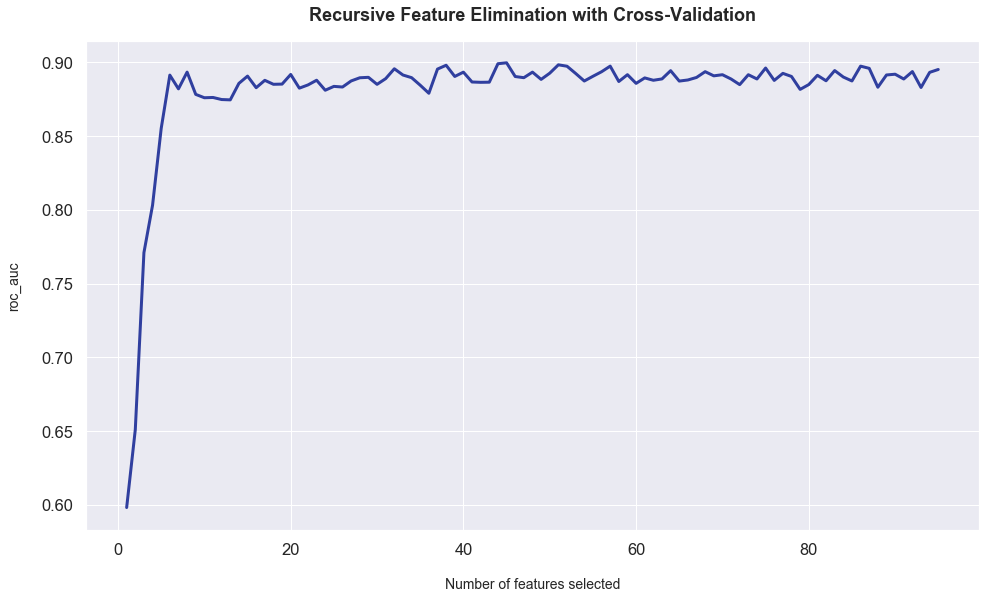

In [101]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('roc_auc', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [102]:
rfecv.estimator_.feature_importances_

array([12,  8,  8, 18,  5,  5,  3,  6, 10,  5, 22,  6,  2,  4,  3,  4, 10,
        4, 25, 12, 11, 12, 13, 12,  5,  8,  4,  9,  7, 28, 13,  5,  3,  5,
        2, 12,  7,  4,  5,  8,  6,  9,  2, 14,  8], dtype=int32)

In [103]:
print(np.where(rfecv.support_ == False)[0])

X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 3  4  7  8 10 11 14 16 17 18 22 29 33 35 44 45 46 47 51 55 56 57 60 61
 62 63 66 67 68 69 70 71 72 75 76 77 79 80 81 82 83 84 85 86 87 88 91 92
 93 94]


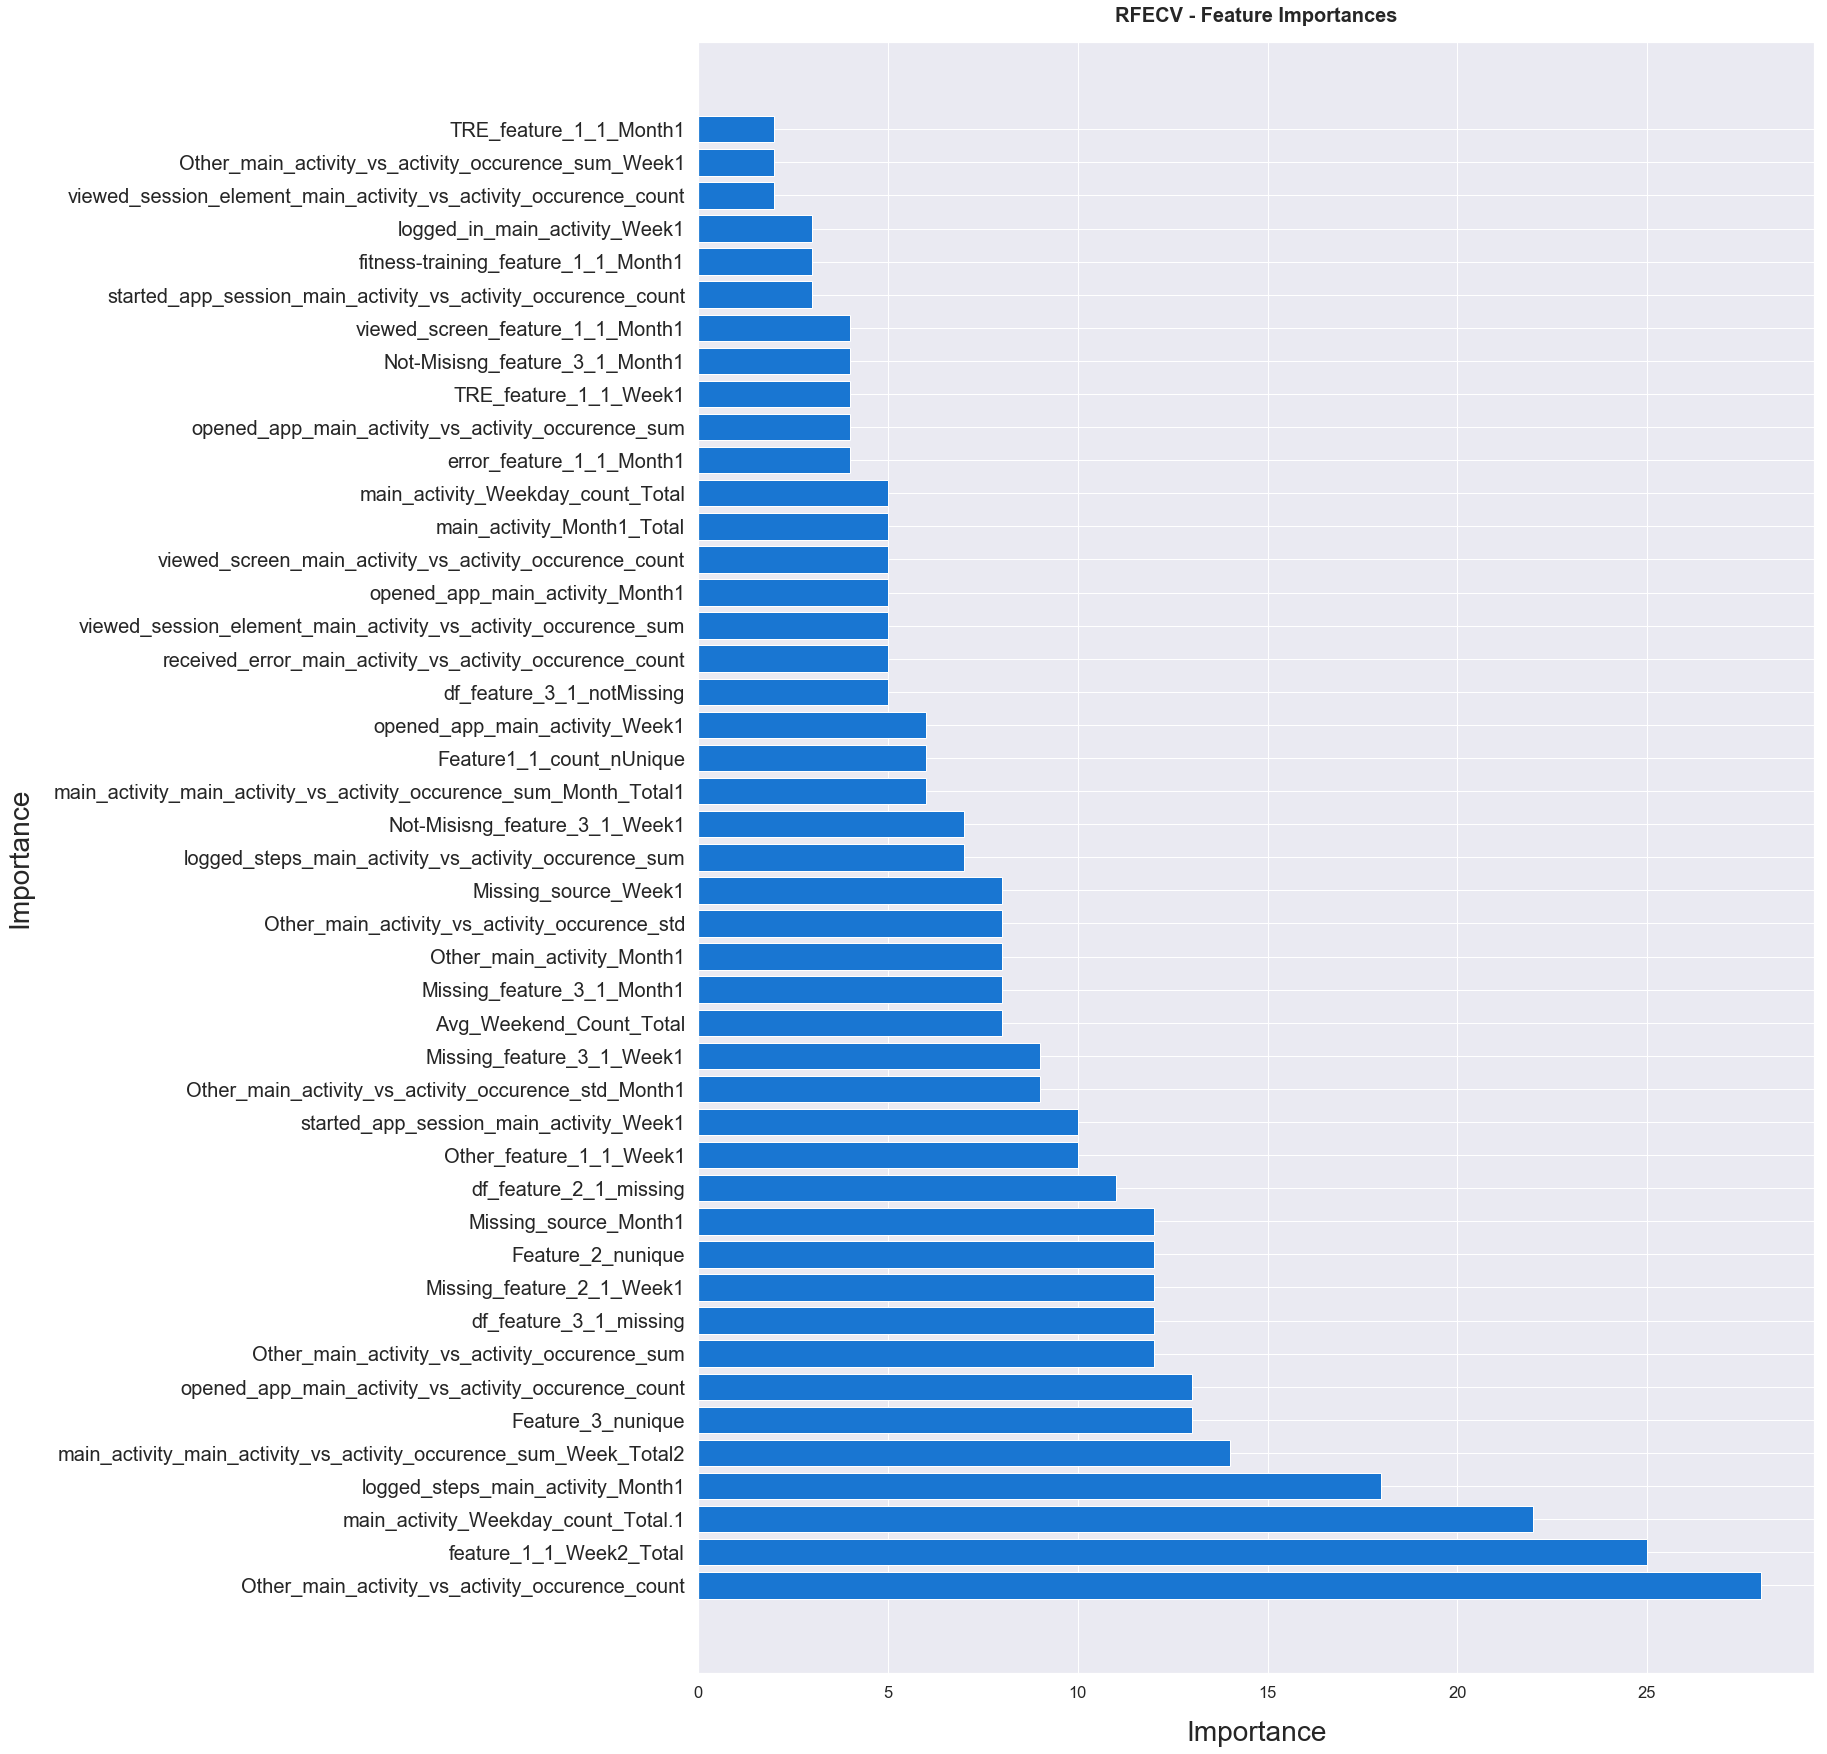

In [105]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 30))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=28, labelpad=20)
plt.ylabel('Importance', fontsize=28, labelpad=20)
plt.yticks(fontsize=20)
plt.show()

In [48]:
#df_streamlit = X_train[selected_feat]#.shape

In [28]:
#df_streamlit.to_csv("df_streamlit.csv", index=False)

In [43]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = lgb_optimized#RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [44]:
# features selected recursively
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9998396665063332
Test set
Random Forests roc-auc: 0.9049707602339181


In [45]:
# features selected recursively
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9940142162364385
Test set
Random Forests roc-auc: 0.9119883040935672


In [728]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(lgb_optimized,  # 4 computer core being used
           k_features=10, # 15 features want to be selected
           forward=True, # step backward
           floating=False, 
           verbose=0,
           scoring='roc_auc', # as it is classification
           cv=5)
sfs1 = sfs1.fit(np.array(X_train), y_train)

In [729]:
selected_feat2= X_train.columns[list(sfs1.k_feature_idx_)]
selected_feat2

Index(['segment_ios_source_Month2', 'logged_daily_mindfulness_main_activity_Week3', 'main_activity_Week3_Total', 'Other_feature_1_1_Week2', 'Missing_feature_3_1_Week2', 'Other_main_activity_vs_activity_occurence_count', 'interacted_with_media_main_activity_vs_activity_occurence_sum', 'Other_main_activity_vs_activity_occurence_std_Week2', 'logged_elevated_heart_rate_main_activity_vs_activity_occurence_sum_Week3', 'userwise_total_activities'], dtype='object')

In [730]:
selected_feat

Index(['main_activity_Weekday_count_Total.1', 'TRE_feature_1_1_Month1', 'Other_feature_1_1_Week2', 'df_feature_3_1_missing', 'Missing_feature_3_1_Week1', 'Not-Misisng_feature_3_1_Week1', 'Not-Misisng_feature_3_1_Week4', 'Other_main_activity_vs_activity_occurence_count', 'Other_main_activity_vs_activity_occurence_std', 'Other_main_activity_vs_activity_occurence_std_Month1'], dtype='object')

In [731]:
#z = list(selected_feat2)+['logged_steps_main_activity_Month1']
#len(z)

In [732]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = lgb_optimized#RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [733]:
# ALL features 
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9998396665063332
Test set
Random Forests roc-auc: 0.9049707602339181


In [734]:
# features selected STE-forward #30 picks IS BEST SO FAR
run_randomForests(X_train[selected_feat2],
                  X_test[selected_feat2],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9877344877344878
Test set
Random Forests roc-auc: 0.8870614035087719


In [443]:
# features selected STE-forward #30 picks IS BEST SO FAR
run_randomForests(X_train[z],
                  X_test[z],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9953236064347176
Test set
Random Forests roc-auc: 0.8836257309941521


In [382]:
# common features between RFE and step-forward elimination

a = [col for col in selected_feat2 if col in selected_feat]

In [383]:
# Uncommon features between RFE and step-forward elimination
b = [col for col in selected_feat2 if col not in selected_feat]

In [384]:
c = [col for col in selected_feat if col not in selected_feat2]

In [385]:
len(a+b+c)

41

In [386]:
d = a+b+c
list(set(d))

['Other_main_activity_Month1',
 'Not-Misisng_feature_3_1_Month1',
 'Missing_source_Month1',
 'logged_in_main_activity_vs_activity_occurence_sum_Week1',
 'viewed_session_element_main_activity_vs_activity_occurence_count',
 'fitness-training_feature_1_1_Week1',
 'Other_main_activity_vs_activity_occurence_count',
 'Other_main_activity_vs_activity_occurence_std',
 'main_activity_main_activity_vs_activity_occurence_sum_Month_Total1',
 'opened_app_main_activity_vs_activity_occurence_count',
 'main_activity_main_activity_vs_activity_occurence_sum_Week_Total2',
 'Feature_2_nunique',
 'df_feature_3_1_missing',
 'error_feature_1_1_Month1',
 'main_activity_Weekday_nunique_Total.1',
 'started_session_main_activity_Month1',
 'Not-Misisng_feature_3_1_Week1',
 'Other_main_activity_vs_activity_occurence_sum_Month1',
 'Missing_feature_1_1_Month1',
 'main_activity_Weekday_nunique_Total',
 'received_error_main_activity_Week1',
 'shared_apple_data',
 'df_feature_3_1_notMissing',
 'Missing_feature_3_1_Week1',
 'started_app_session_main_activity_vs_activity_occurence_count',
 'Other_feature_1_1_Week1',
 'started_app_session_main_activity_Week1',
 'Missing_feature_2_1_Week1',
 'Feature1_1_count_nUnique',
 'Feature_3_nunique',
 'Not-Misisng_feature_2_1_Week2',
 'received_error_main_activity_vs_activity_occurence_std_Week1',
 'viewed_screen_main_activity_vs_activity_occurence_count',
 'main_activity_Weekday_count_Total.1',
 'Other_main_activity_vs_activity_occurence_std_Month1',
 'Other_main_activity_vs_activity_occurence_sum',
 'started_app_session_main_activity_vs_activity_occurence_sum_Month1',
 'Other_main_activity_Week1',
 'logged_steps_main_activity_Month1',
 'main_activity_Month1_Total',
 'feature_1_1_Week2_Total']

In [387]:
# features selected STE-forward #30 picks IS BEST SO FAR
run_randomForests(X_train[d],
                  X_test[d],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9992784992784992
Test set
Random Forests roc-auc: 0.9033625730994151


# Try modeling separately with RFE and step-forward elimination

In [50]:
# Models
logreg = LogisticRegression(random_state=0) 
randomforest = RandomForestClassifier(random_state=0, class_weight="balanced") 
gbk = GradientBoostingClassifier(random_state=0) 
xgb = XGBClassifier()
lgb = LGBMClassifier(boosting_type='gbdt',class_weight='balanced')

# Splititng data into train and test set
df_x = df_log[selected_feat2]
X = df_x
y = df2['subscription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

index = X_train.index
cols = X_train.columns
index1 = X_test.index
cols1 = X_test.columns
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=index, columns=cols)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, index=index1, columns=cols1)

NameError: name 'selected_feat2' is not defined

In [53]:
df_streamlit.shape
y = 

(387, 7)

In [51]:
# Models
logreg = LogisticRegression(random_state=0) 
randomforest = RandomForestClassifier(random_state=0, class_weight="balanced") 
gbk = GradientBoostingClassifier(random_state=0) 
xgb = XGBClassifier()
lgb = LGBMClassifier(boosting_type='gbdt',class_weight='balanced')

# Splititng data into train and test set
df_x = df_streamlit
X = df_x
y = df2['subscription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

index = X_train.index
cols = X_train.columns
index1 = X_test.index
cols1 = X_test.columns
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=index, columns=cols)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, index=index1, columns=cols1)

ValueError: Found input variables with inconsistent numbers of samples: [387, 553]

In [737]:
X_train.shape, X_test.shape

((387, 10), (166, 10))

In [738]:
def cross_validation(X,y,scoring):
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0) 
    xyz=[] 
    accuracy_cv=[]
    classifiers=['LogisticRegression','RandomForest','GradientBoosting', 'XGBoost', 'LightGBM'] 
    models = [logreg,randomforest, gbk, xgb, lgb]
    for i in models:
        model = i
        cv_result = cross_val_score(model, X, y, cv=kfold, scoring = scoring)
        cv_result=cv_result
        xyz.append(cv_result.mean())
        accuracy_cv.append(cv_result)
    new_models_dataframe2 = pd.DataFrame({'CV Mean':xyz},index=classifiers) 
    new_models_dataframe2.loc['avg'] = new_models_dataframe2.mean()
    return new_models_dataframe2
    return accuracy_cv

cv_1 = cross_validation(X_train,y_train, scoring='precision')
cv_2 = cross_validation(X_train,y_train, scoring='recall')
cv_3 = cross_validation(X_train,y_train, scoring='roc_auc')

cv_comp = pd.concat([cv_1, cv_2, cv_3], axis=1)
cv_comp.columns = ['Precision_CV_mean', 'Recall_CV_mean', 'ROC-AUC_CV_mean']
cv_comp.sort_values(by='Precision_CV_mean', ascending=False)
cv_comp.loc['avg'] =cv_comp.mean()
cv_comp

Precision_CV_mean  Recall_CV_mean  ROC-AUC_CV_mean
LogisticRegression           0.764119        0.793120         0.845736
RandomForest                 0.867910        0.802267         0.927320
GradientBoosting             0.832932        0.853698         0.935938
XGBoost                      0.826580        0.864432         0.941005
LightGBM                     0.892095        0.857964         0.938169
avg                          0.836727        0.834296         0.917634

In [450]:
X_train.shape, y_train.shape

((387, 10), (387,))

# Auto-optimization of hyper-parameters
from hyperopt import fmin, tpe, hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    
    #if t == 'randomforest':
    #    clf = RandomForestClassifier(**params, random_state=0)

   # if t == 'gradientboost':
    #    clf = GradientBoostingClassifier(**params, random_state=0) 
        
    if t == 'XGBboost':
        clf = XGBClassifier(**params, random_state=0) 
        
    if t == 'LightGBM':
        clf = LGBMClassifier(**params, random_state=0)
        
    else:
        return 0 
    
    return cross_val_score(clf, X_train, y_train, cv=kfold, scoring='recall', n_jobs=-1).mean()


space = hp.choice('classifier_type', [
        {
        'type': 'XGBboost',
        'max_depth': hp.choice('max_depth3', range(1,20)),
        'min_samples_split': hp.choice('min_samples_split3', range(2,10)), # change this
        'min_samples_leaf': hp.choice('min_samples_leaf', range(2,10)),
        'max_features': hp.choice('max_features3', ['auto','np.sqrt', 'np.log']),
        'subsample':hp.choice('subsample', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'n_estimators': hp.choice('n_estimators3', range(10,500,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    
        {
        'type': 'LightGBM',
        'max_depth': hp.choice('max_depth4', range(1,15)),
        'max_features': hp.choice('max_features4', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators4', range(10,500,20)),
        "min_samples_split": hp.choice('min_samples_split4', range(2,15)),
        'learning_rate': hp.choice('learning_rate2', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        'loss': hp.choice('loss2', ['deviance', 'exponential']),
        'bagging_freq': hp.choice('bagging_freq', range(1,15)),
        'subsample_for_bin': hp.choice('subsample_for_bin', [200000, 300000, 400000]),
        'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'subsample':hp.choice('subsample2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
    },

])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        #print ('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        print('')
        #print ('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=15000, trials=trials)
print ('best:')
print (best)

lgb = LGBMClassifier(random_state=0)

def tune(model, grid):
    #kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    gs = GridSearchCV(estimator=model, param_grid=grid, cv=kfold, n_jobs=10, verbose=1, scoring='f1')
    gs.fit(X_train, y_train) 
    print('Best score: ', gs.best_score_)
    print('Best params: ', gs.best_params_)
    #print('cv results: ', gs.cv_results_)
    print('Best estimator: ', gs.best_estimator_)

parameters = {
    "loss":["deviance"],#,'exponential'],
    #"learning_rate": [0.05, 0.1, 0.15, 0.2],                        , 0.15, 0.2, 0.5],
    #"min_samples_split": np.linspace(0.1, 0.5, 3),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[9,10,11],
    "max_features":['auto'],#,'np.sqrt', 'np.log'],
   # "criterion": ["friedman_mse",  "mae"],
   # "subsample":[0.9, 0.95, 1.0],
    "n_estimators":range(20,50,5),
    "min_samples_split":[1,2],
    'learning_rate':[0.925, 0.95, 0.975],
    'bagging_freq':[2,3,4],
    'subsample_for_bin':[30000,35000,40000],
    'colsample_bytree':[0.5, 0.55,0.6],
    'subsample':[0.925, 0.95,0.975]
    }

tune(lgb, parameters)

In [451]:
X_train.shape, y_train.shape

((387, 10), (387,))

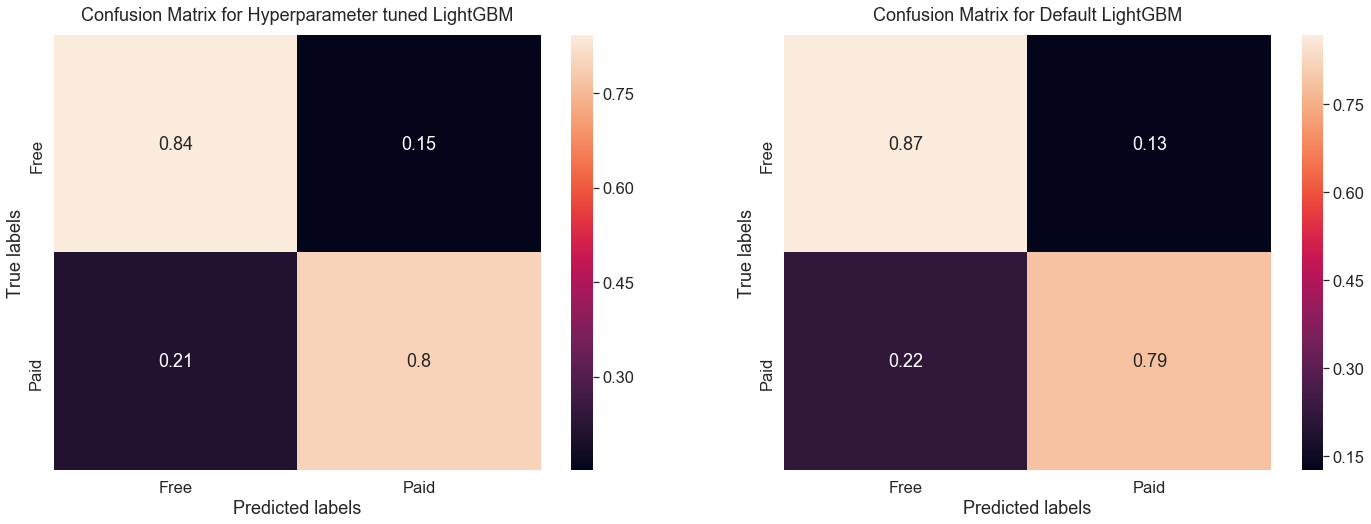

In [452]:
lgb_optimized2 = LGBMClassifier(bagging_freq=2,colsample_bytree=0.55,learning_rate=0.95, loss='deviance', max_depth=10,
                     max_features='auto',min_samples_split=1,n_estimators=40, n_jobs=-1,random_state=0,
                     subsample=0.95, subsample_for_bin=300000)

#(bagging_freq=8,colsample_bytree=0.9,learning_rate=0.175, loss='deviance', max_depth=6,
                 #    max_features='auto',min_samples_split=2,n_estimators=35, n_jobs=-1,random_state=0,
                 #    subsample=0.9, subsample_for_bin=150000)\\
lgb_default2 = LGBMClassifier(random_state=0)

models = [lgb_optimized2, lgb_default2]
model_names = ['Hyperparameter tuned LightGBM', 'Default LightGBM']

from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        y_pred = cross_val_predict(models[i], X, y, cv=kfold)
        #labels = ['Free-Tier', 'Paid-Subscriber']
        C = confusion_matrix(y,y_pred)
        C = C / C.astype(np.float).sum(axis=1)
        sns.heatmap(C,ax=ax[i],annot=True)
        #confusion_matrix(y,y_pred)
        ax[i].set_title('Confusion Matrix for '+ model_names[i], pad=15) 
        # labels, title and ticks
        ax[i].set_xlabel('Predicted labels');ax[i].set_ylabel('True labels');  
        ax[i].xaxis.set_ticklabels(['Free', 'Paid']); ax[i].yaxis.set_ticklabels(['Free', 'Paid']);
        
fig, ax = plt.subplots(1,2,figsize=(24,8))
confusion_matrix_plot(X_train, y_train)

In [453]:
import eli5
from eli5.sklearn import PermutationImportance
lgb_optimized2.fit(X_train, y_train)
perm = PermutationImportance(lgb_optimized2, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [402]:
# Finding most important features
#print(X_train.columns) 
#models = [lgb_optimized, rf, xgb, gbk]
#model_name = ['LightGBM_optimized', 'XGBoost', 'RandomForest', 'GradientBoost']

#f,ax=plt.subplots(4,1,figsize=(18,70), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
#ax = ax.ravel()
#for i in range(len(models)):
 #   models[i].fit(X_train, y_train)
    
  #  x = pd.Series(models[i].feature_importances_, X_train.columns).sort_values(ascending=True)
   # #x = x[x>5] 
    #x.plot(kind='barh',ax=ax[i])                                                    
    #ax[i].set_title('Feature Importance in ' + model_name[i], size=34)

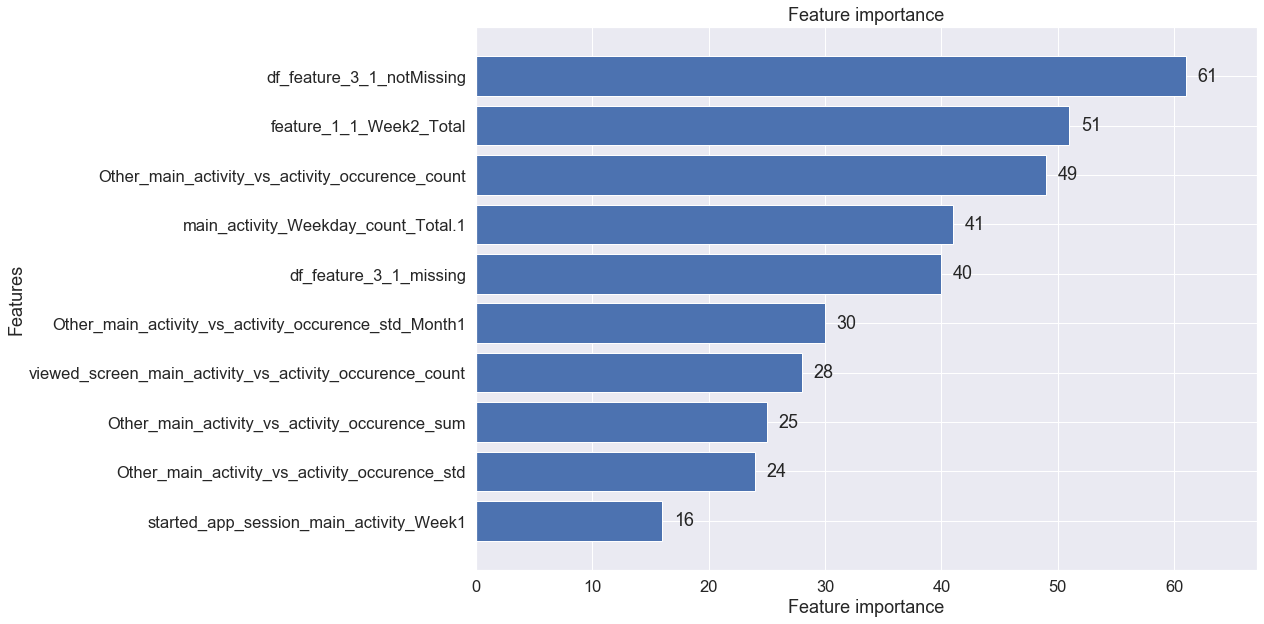

In [454]:
# Finding most important features
#print(X_train.columns) 
models = [lgb_optimized2]#, rf, xgb, gbk]
model_name = ['LightGBM_optimized']#, 'XGBoost', 'RandomForest', 'GradientBoost']

f,ax=plt.subplots(figsize=(14,10), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
#ax = ax.ravel()
for i in range(len(models)):
    #models[i].fit(X_train, y_train)
    
   # x = pd.Series(models[i].feature_importances_, X_train.columns).sort_values(ascending=True)
   # x = x[x>10] 
   # x.plot(kind='barh',ax=ax)                                                    
   # ax.set_title('Feature Importance in ' + model_name[i], size=24, pad=20)
    
    
    g1 = lightgbm.plot_importance(lgb_optimized,ax=ax,max_num_features=15,height=.8,grid=True)

Index(['started_app_session_main_activity_Week1', 'main_activity_Weekday_count_Total.1', 'feature_1_1_Week2_Total', 'df_feature_3_1_missing', 'df_feature_3_1_notMissing', 'Other_main_activity_vs_activity_occurence_count', 'viewed_screen_main_activity_vs_activity_occurence_count', 'Other_main_activity_vs_activity_occurence_sum', 'Other_main_activity_vs_activity_occurence_std', 'Other_main_activity_vs_activity_occurence_std_Month1'], dtype='object')


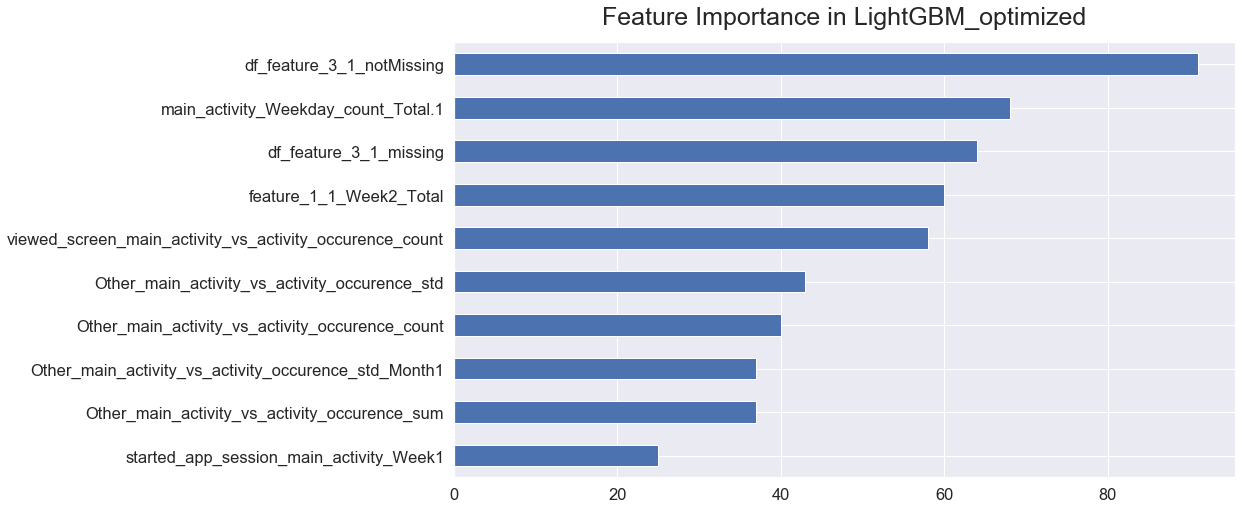

In [463]:
# Finding most important features
print(X_train.columns) 
models = [lgb_optimized2]#, rf, xgb, gbk]
model_name = ['LightGBM_optimized']#, 'XGBoost', 'RandomForest', 'GradientBoost']

f,ax=plt.subplots(1,1,figsize=(14,8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
#ax = ax.ravel()
for i in range(len(models)):
    models[i].fit(X_train, y_train)
    
    x = pd.Series(models[i].feature_importances_, X_train.columns).sort_values(ascending=True)
    #x = x[x>5] 
    x.plot(kind='barh',ax=ax)                                                    
    ax.set_title('Feature Importance in ' + model_name[i], size=25, pad=18)

In [472]:
x=x.index


AttributeError: 'Index' object has no attribute 'index'

## Interpretation of the result

In [473]:
x = list(x)
x

['started_app_session_main_activity_Week1',
 'Other_main_activity_vs_activity_occurence_sum',
 'Other_main_activity_vs_activity_occurence_std_Month1',
 'Other_main_activity_vs_activity_occurence_count',
 'Other_main_activity_vs_activity_occurence_std',
 'viewed_screen_main_activity_vs_activity_occurence_count',
 'feature_1_1_Week2_Total',
 'df_feature_3_1_missing',
 'main_activity_Weekday_count_Total.1',
 'df_feature_3_1_notMissing']

In [612]:
corr_df = pd.read_csv("balanced_data_correlated_groups.csv")
corr_df_num = corr_df.select_dtypes('number')
corr_df_num.head(2)

Missing_source_Month1  segment_ios_source_Month1  segment_tre_source_Month1  Missing_source_Month2  segment_ios_source_Month2  segment_tre_source_Month2  Missing_source_Week1  segment_ios_source_Week1  segment_tre_source_Week1  Missing_source_Week2  segment_ios_source_Week2  segment_tre_source_Week2  Missing_source_Week3  segment_ios_source_Week3  segment_tre_source_Week3  Missing_source_Week4  segment_ios_source_Week4  segment_tre_source_Week4  Missing_source_Week5  segment_ios_source_Week5  segment_tre_source_Week5  Missing_source_Week6  segment_ios_source_Week6  segment_tre_source_Week6  Missing_source_Week7  segment_ios_source_Week7  segment_tre_source_Week7  Missing_source_Week8  segment_ios_source_Week8  segment_tre_source_Week8  Other_main_activity_Month1  closed_session_main_activity_Month1  completed_session_main_activity_Month1  identified_app_user_main_activity_Month1  interacted_with_media_main_activity_Month1  logged_daily_mindfulness_main_activity_Month1  \
0                  408.0                      135.0                        NaN                    NaN                        NaN                        NaN                 408.0                     135.0                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                        58.0                                 14.0                                     6.0                                       2.0                                        41.0                                            NaN   
1                   42.0                       69.0                        NaN                    NaN                        NaN                        NaN                  42.0                      69.0                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                   NaN                       NaN                       NaN                        19.0                                  2.0                                     2.0                                       2.0                                         NaN                                            NaN   

   logged_daily_sleep_main_activity_Month1  logged_daily_weight_main_activity_Month1  logged_elevated_heart_rate_main_activity_Month1  logged_in_main_activity_Month1  logged_steps_main_activity_Month1  opened_app_main_activity_Month1  pressed_next_main_activity_Month1  started_session_main_activity_Month1  viewed_screen_main_activity_Month1  viewed_session_element_main_activity_Month1  main_activity_Month1_Total  Other_main_activity_Month2  closed_session_main_activity_Month2  completed_session_main_activity_Month2  identified_app_user_main_activity_Month2  interacted_with_media_main_activity_Month2  logged_daily_mindfulness_main_activity_Month2  logged_daily_sleep_main_activity_Month2  logged_daily_weight_main_activity_Month2  logged_elevated_heart_rate_main_activity_Month2  logged_in_main_activity_Month2  logged_steps_main_activity_Month2  opened_app_main_activity_Month2  pressed_next_main_activity_Month2  received_error_main_activity_Month2  \
0                                      NaN                                

In [613]:
corr_df.shape, corr_df_num.shape

((553, 820), (553, 818))

In [614]:
cols_2_drop = corr_df_num.columns[corr_df_num.isna().mean()>.4]
len(cols_2_drop)
corr_df2 = corr_df_num.drop(columns=cols_2_drop)
corr_df2.shape

(553, 117)

In [695]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(corr_df2,df2['subscription'],test_size=0.3,random_state=0)
# Use previous standard scaler
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_train1 = pd.DataFrame(X_train1, index=X_train.index,columns=X_train.columns)
X_test1 = sc.transform(X_test)
X_test1 = pd.DataFrame(X_test1, index=X_test.index,columns=X_test.columns)
X_train1.shape, X_test1.shape, y_train.shape, y_test.shape

((387, 117), (166, 117), (387,), (166,))

In [696]:
# build a dataframe with the absolute value of the correlation coefficient between features
corrmat = X_train1.corr()
corrmat = corrmat.abs().unstack() 
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.80]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

feature1                                           feature2      corr
0  logged_steps_main_activity_vs_activity_occuren...  logged_steps_main_activity_vs_activity_occuren...  1.000000
1  logged_steps_main_activity_vs_activity_occuren...  logged_steps_main_activity_vs_activity_occuren...  1.000000
2                 received_error_main_activity_Week1  received_error_main_activity_vs_activity_occur...  1.000000
3  received_error_main_activity_vs_activity_occur...                 received_error_main_activity_Week1  1.000000
4  started_app_session_main_activity_vs_activity_...  started_app_session_main_activity_vs_activity_...  0.999999

Found 8 correlated groups
out of 117 total features 




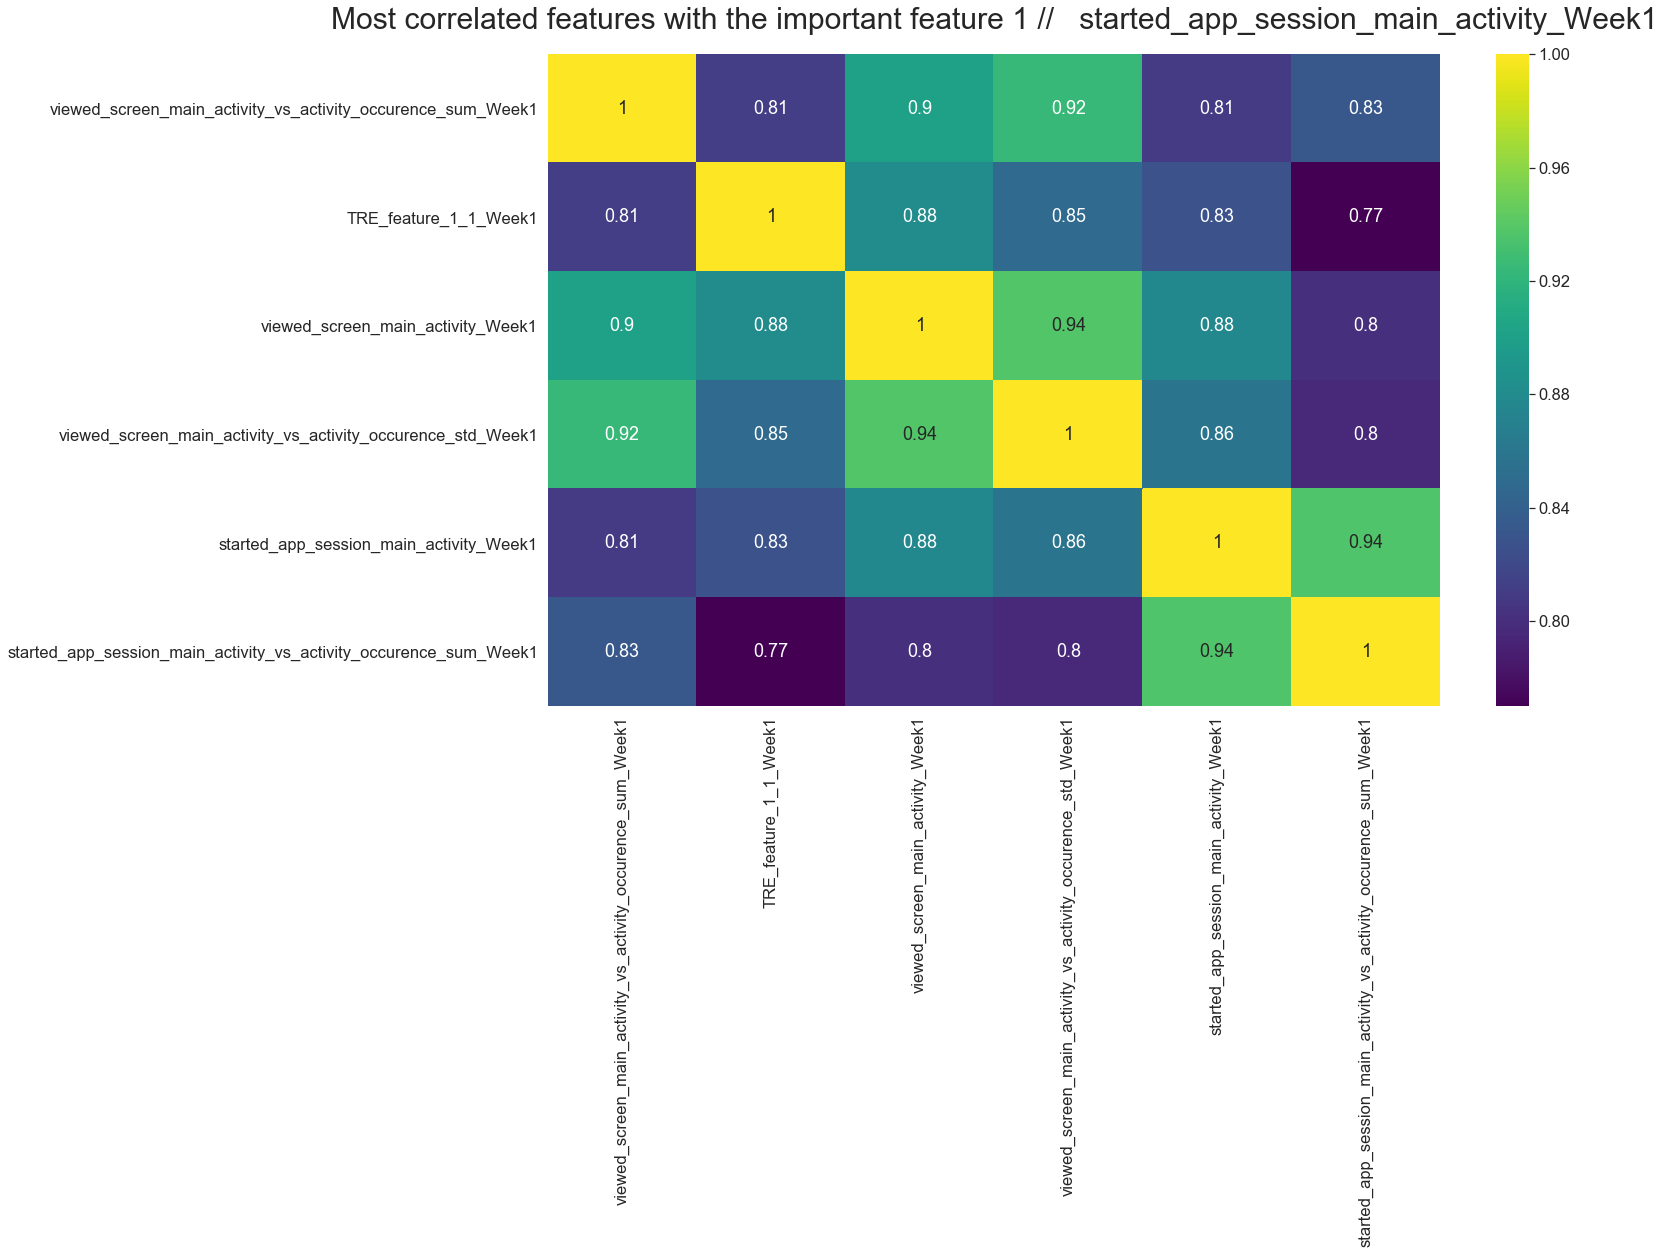

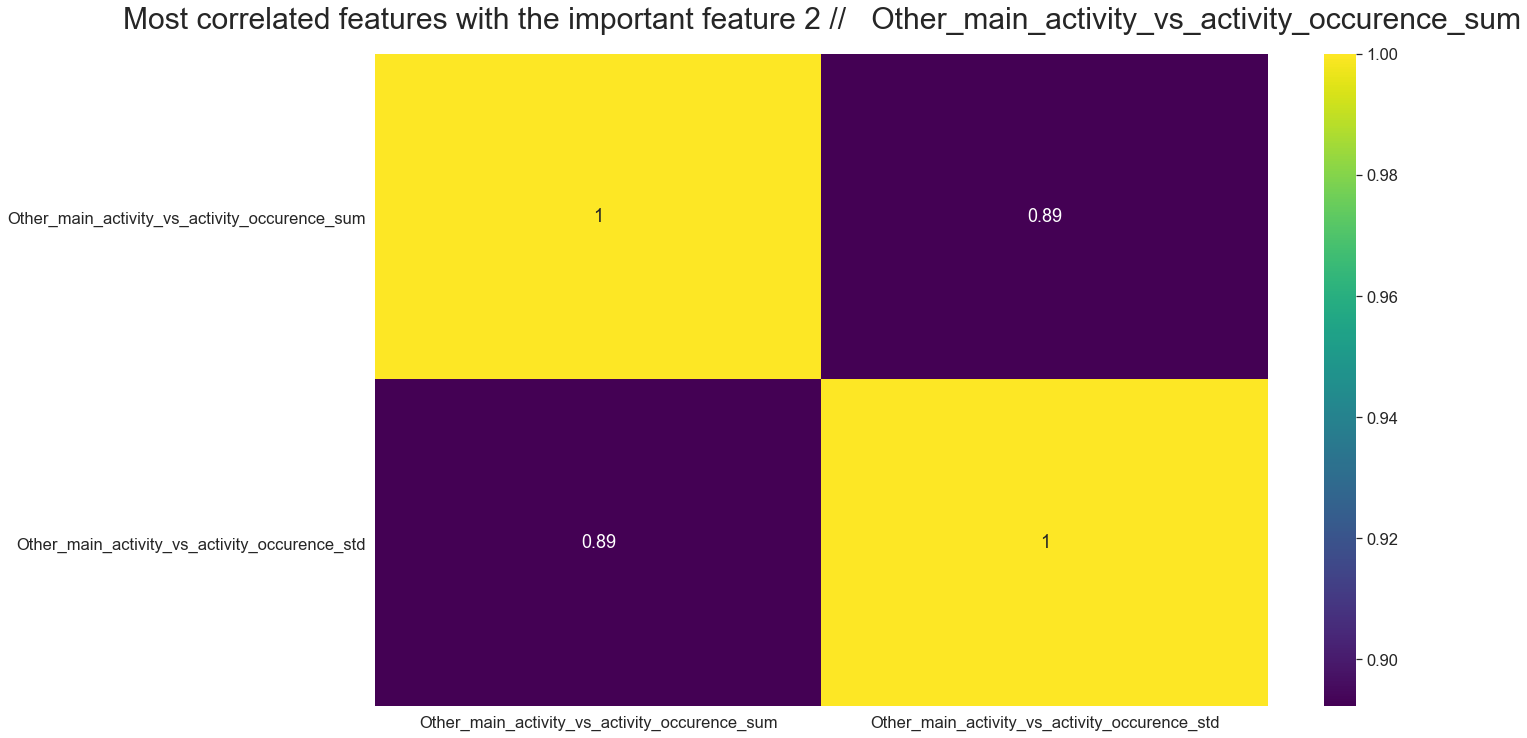

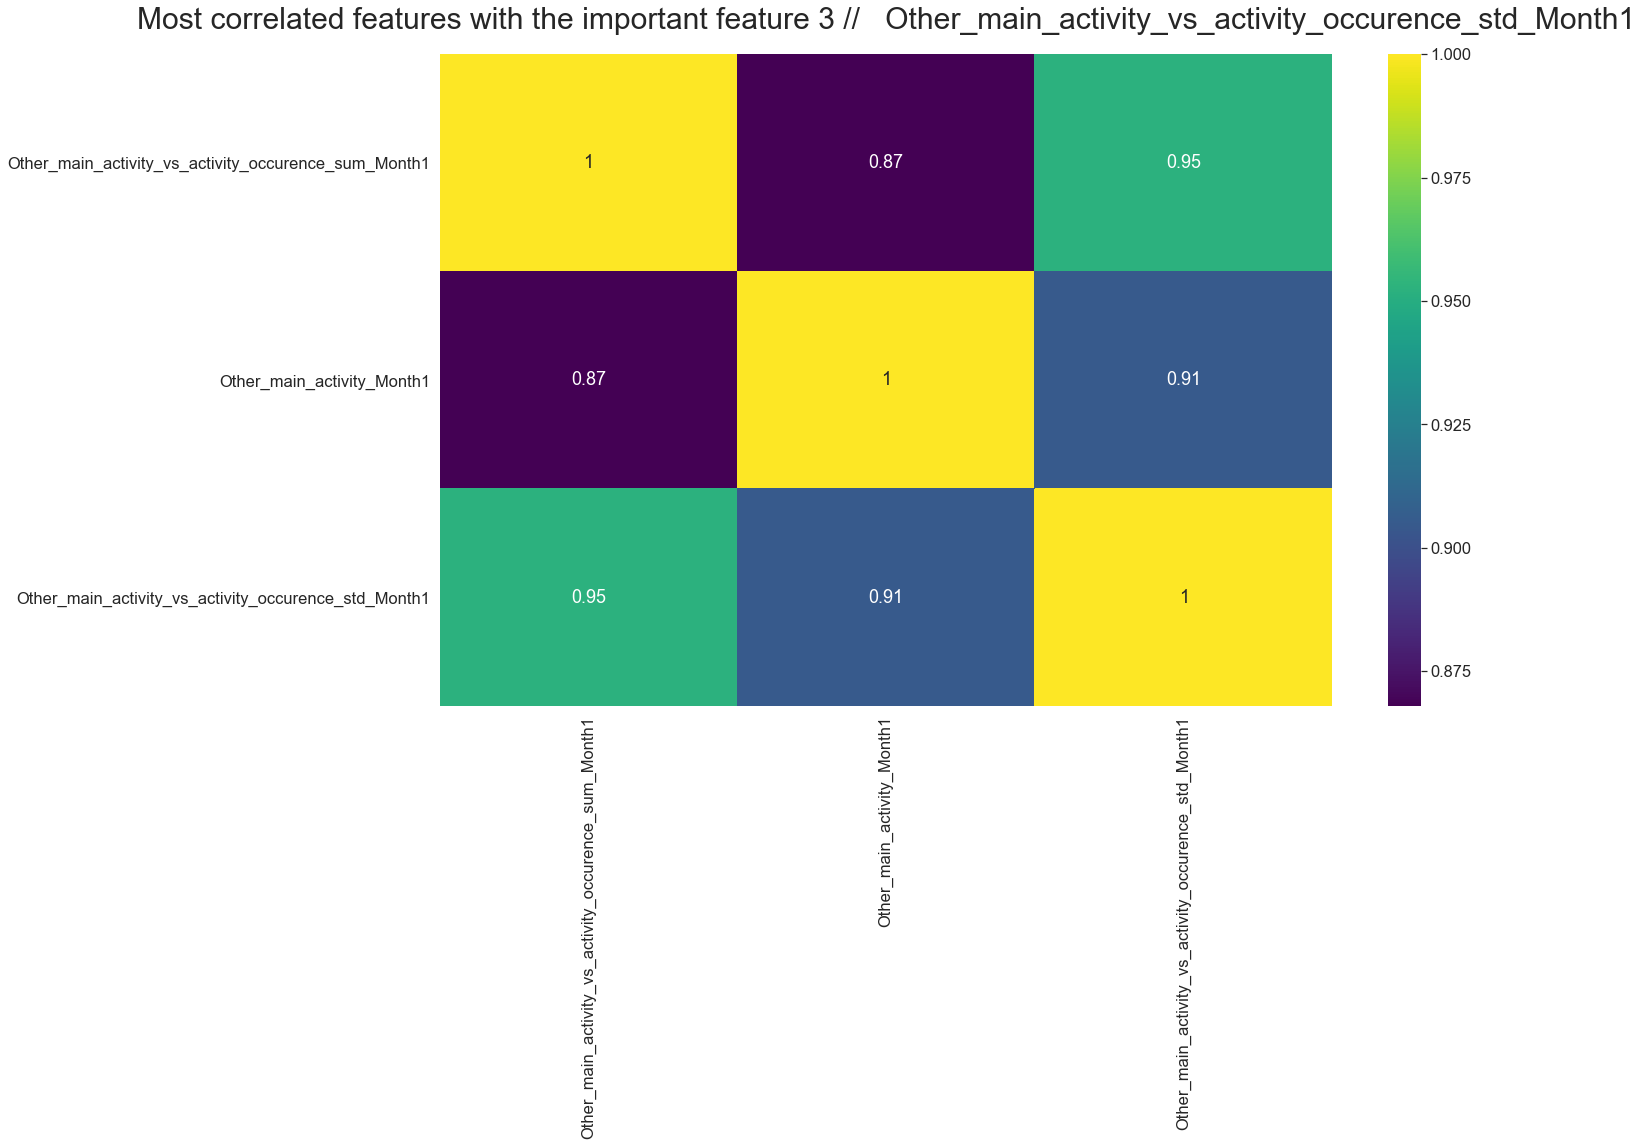

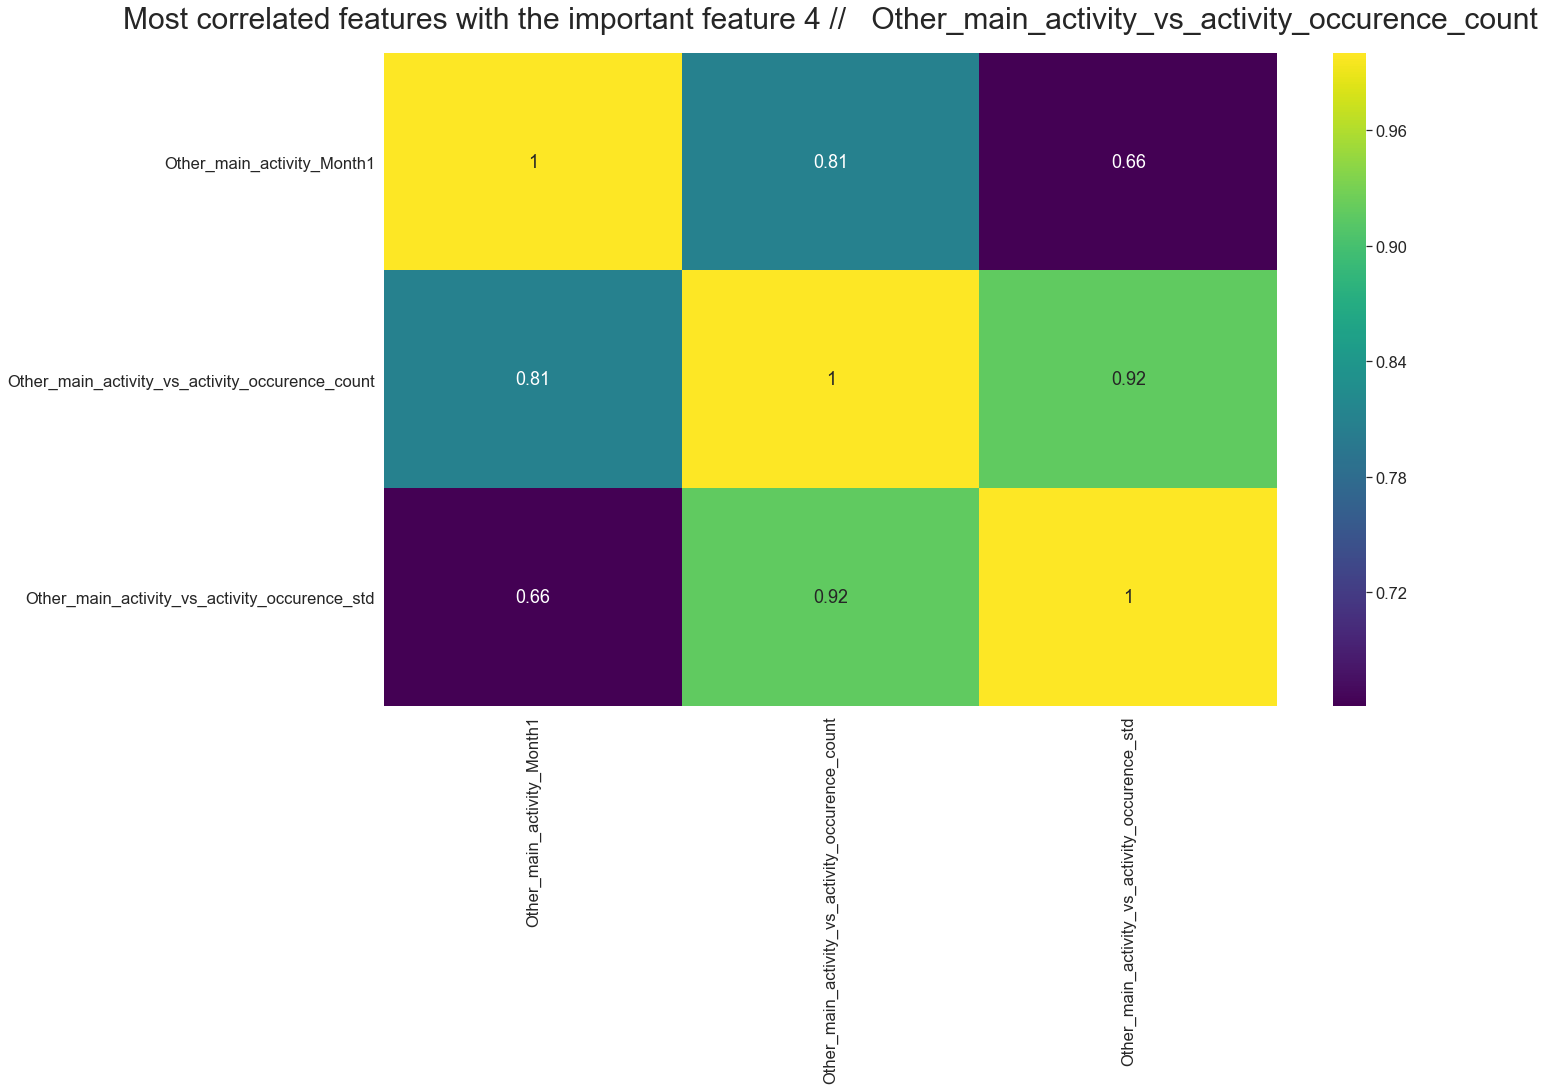

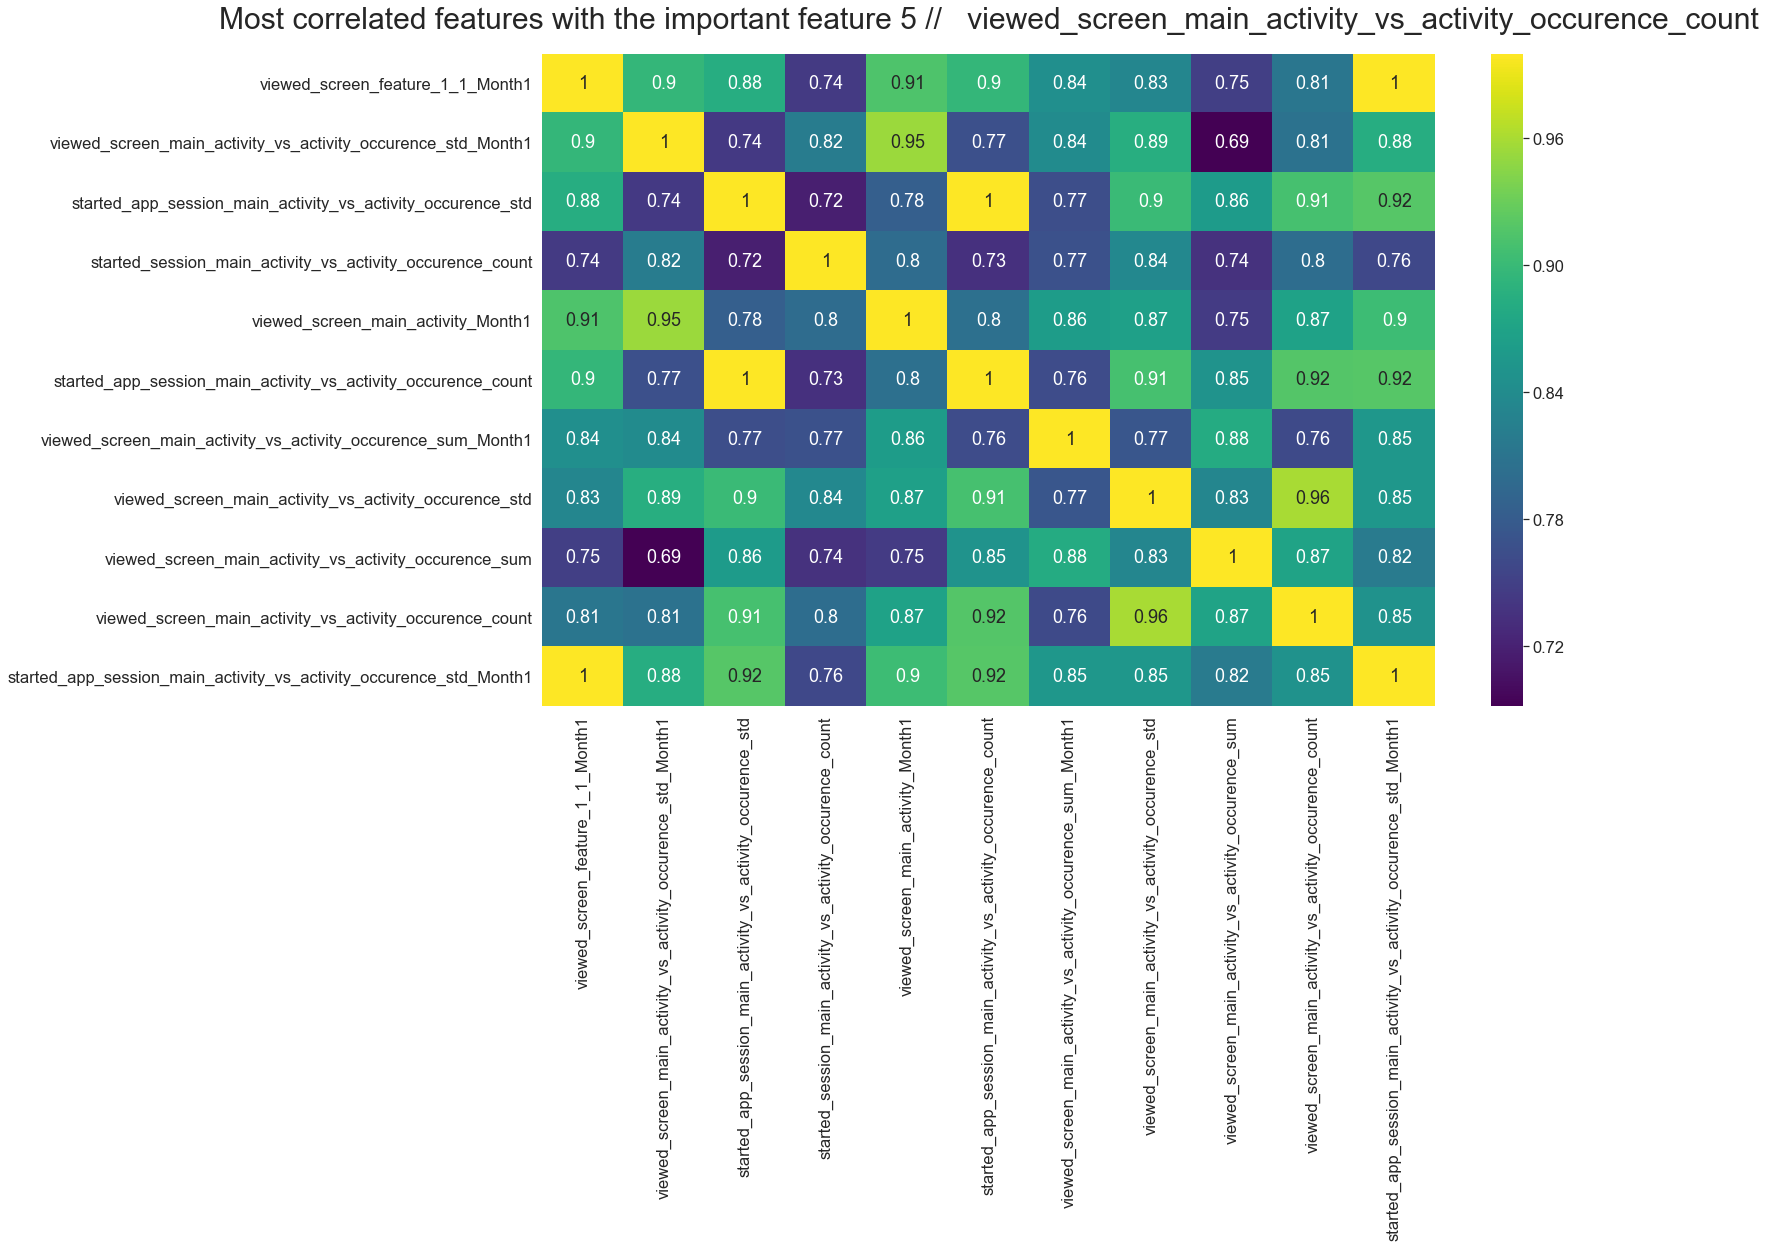

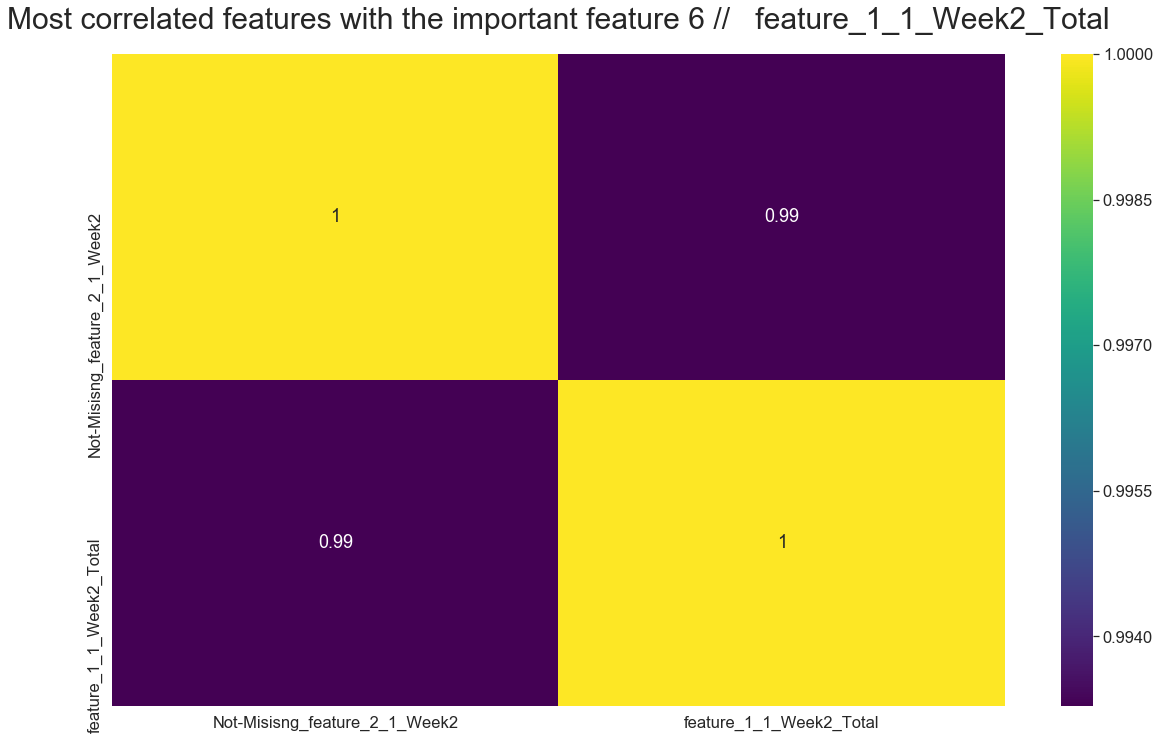

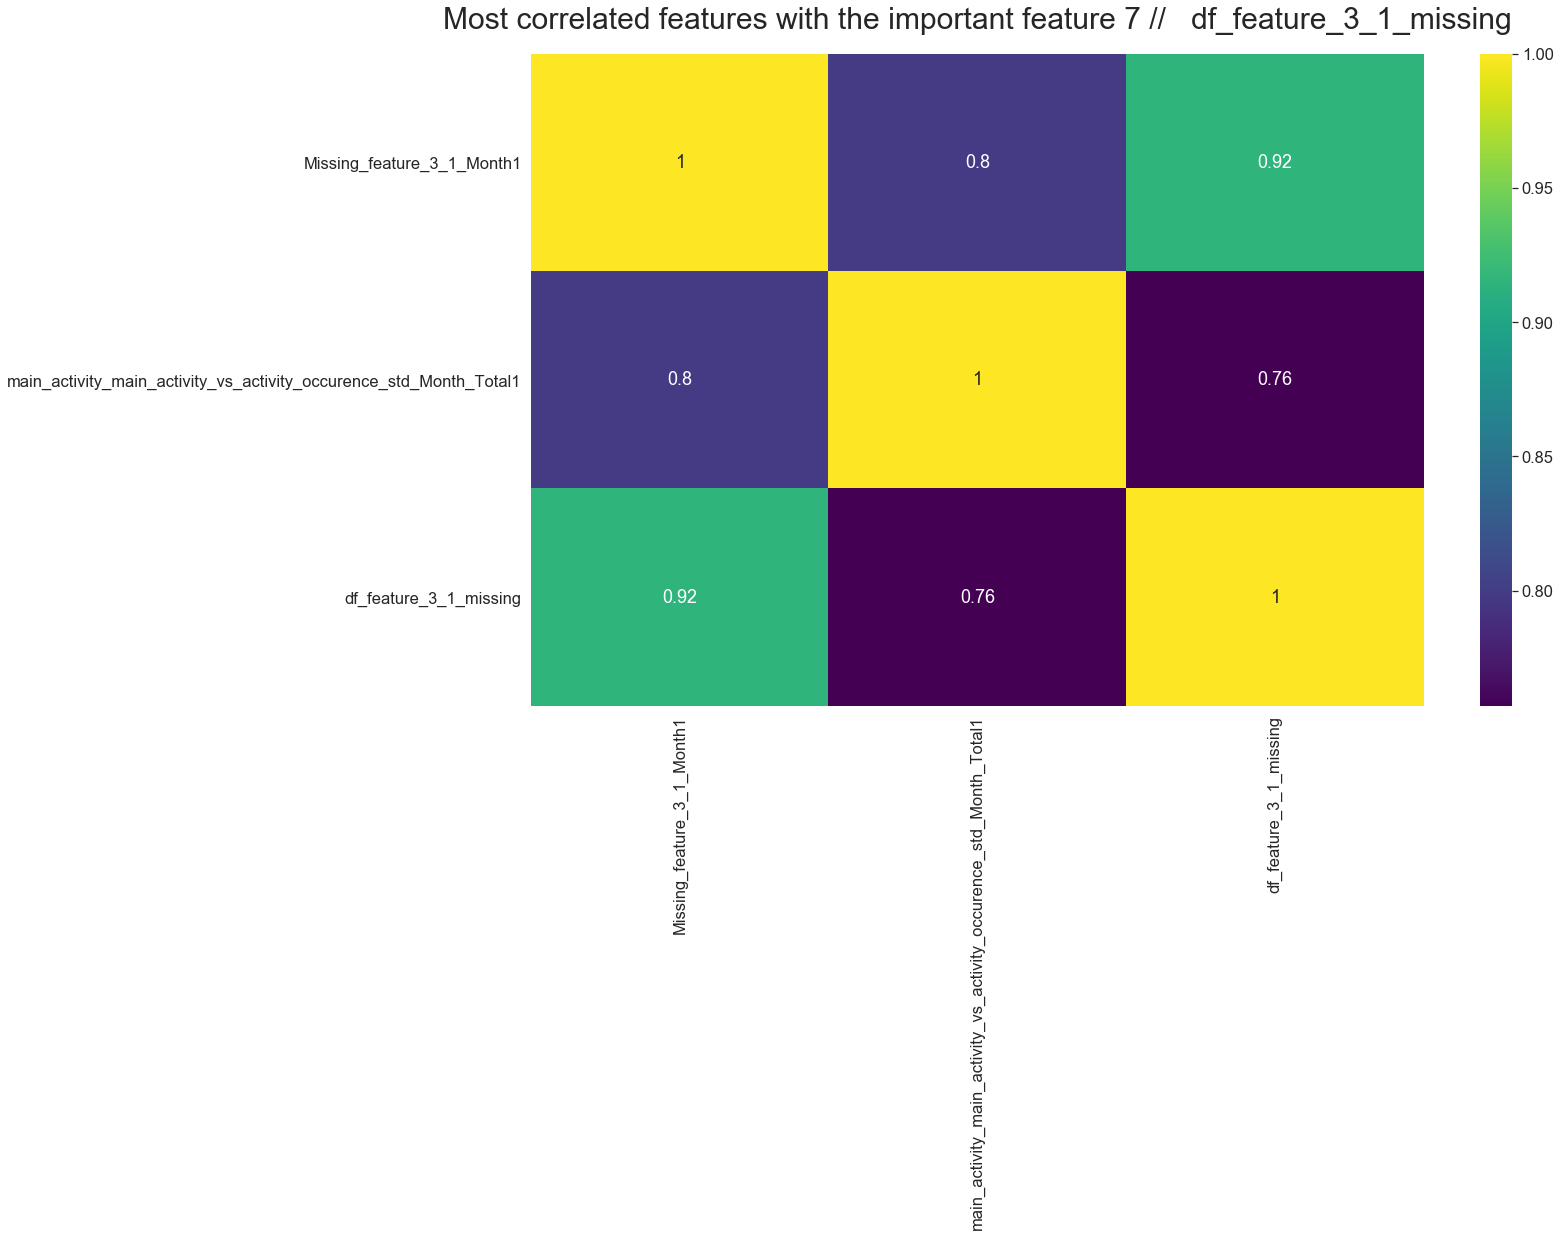

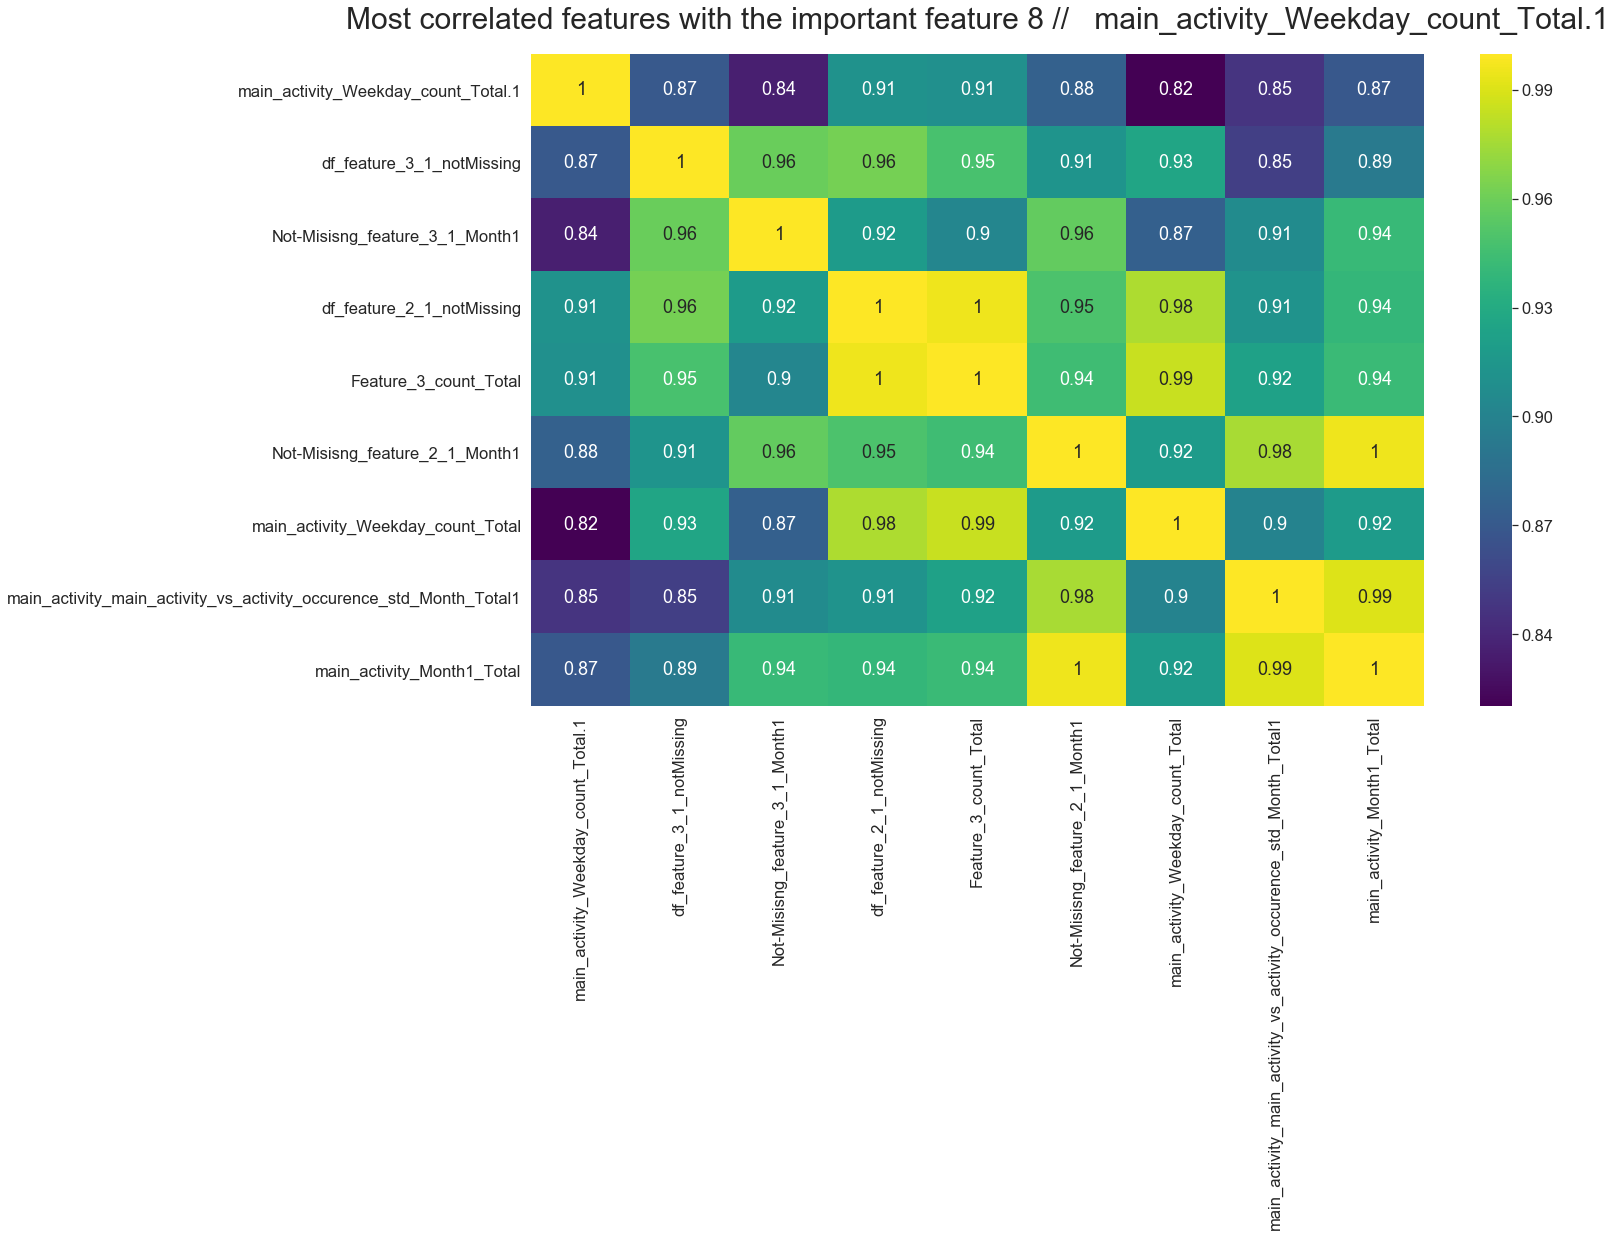

In [697]:
# find groups of correlated features
grouped_feature_ls = []
correlated_groups = []

for feature in x:
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('Found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features \n\n'.format(corr_df2.shape[1]))
print('===='*28)

for i in range(len(correlated_groups)):
    #print(correlated_groups[i])
    #print('\n')
    col_0 = list(set(list(correlated_groups[i]['feature1']) + list(correlated_groups[i]['feature2'])))
    #fig,ax = plt.subplot(figsize=(12,8))
      
    corrmat = corr_df_num[col_0].corr()
    fig, ax = plt.subplots(gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
    ax.set_title('Most correlated features with the important feature '+str(i+1)+' //   '+str(correlated_groups[i]['feature1'].values[0]), size=30,pad=25)  
    fig.set_size_inches(20,12)
    sns.heatmap(corrmat, annot=True, cmap='viridis')
    plt.show()
    print('\n\n\n')
    #fig.tight_layout();

In [694]:
len(correlated_groups)

8

In [642]:
correlated_groups[0]

feature1                                           feature2      corr
134   started_app_session_main_activity_Week1  started_app_session_main_activity_vs_activity_...  0.944452
312   started_app_session_main_activity_Week1                  viewed_screen_main_activity_Week1  0.889758
384   started_app_session_main_activity_Week1  viewed_screen_main_activity_vs_activity_occure...  0.866659
509   started_app_session_main_activity_Week1                              TRE_feature_1_1_Week1  0.836247
607   started_app_session_main_activity_Week1  viewed_screen_main_activity_vs_activity_occure...  0.811464
1004  started_app_session_main_activity_Week1                started_session_main_activity_Week1  0.736024
1115  started_app_session_main_activity_Week1                   viewed_screen_feature_1_1_Month1  0.719936
1142  started_app_session_main_activity_Week1                 viewed_screen_main_activity_Month1  0.716865
1156  started_app_session_main_activity_Week1                            Other_feature_1_1_Week1  0.715791

In [565]:
col_0 = list(set(list(correlated_groups[0]['feature1']) + list(correlated_groups[0]['feature2'])))

In [566]:
corr_df_num[col_0].isna().sum()

viewed_screen_main_activity_vs_activity_occurence_sum_Week1          101
TRE_feature_1_1_Week1                                                 83
viewed_screen_main_activity_Week1                                    101
viewed_screen_main_activity_vs_activity_occurence_std_Week1          112
started_app_session_main_activity_Week1                              100
started_app_session_main_activity_vs_activity_occurence_sum_Week1    100
dtype: int64

In [516]:
list(correlated_groups[0]['feature1']).unique()

AttributeError: 'list' object has no attribute 'unique'

In [568]:
(set(list(correlated_groups[0]['feature1'].values))).add(set(list(correlated_groups[0]['feature2'].values)))

TypeError: unhashable type: 'set'

In [570]:
correlated_groups[0]['feature1'].values[0]

'started_app_session_main_activity_Week1'

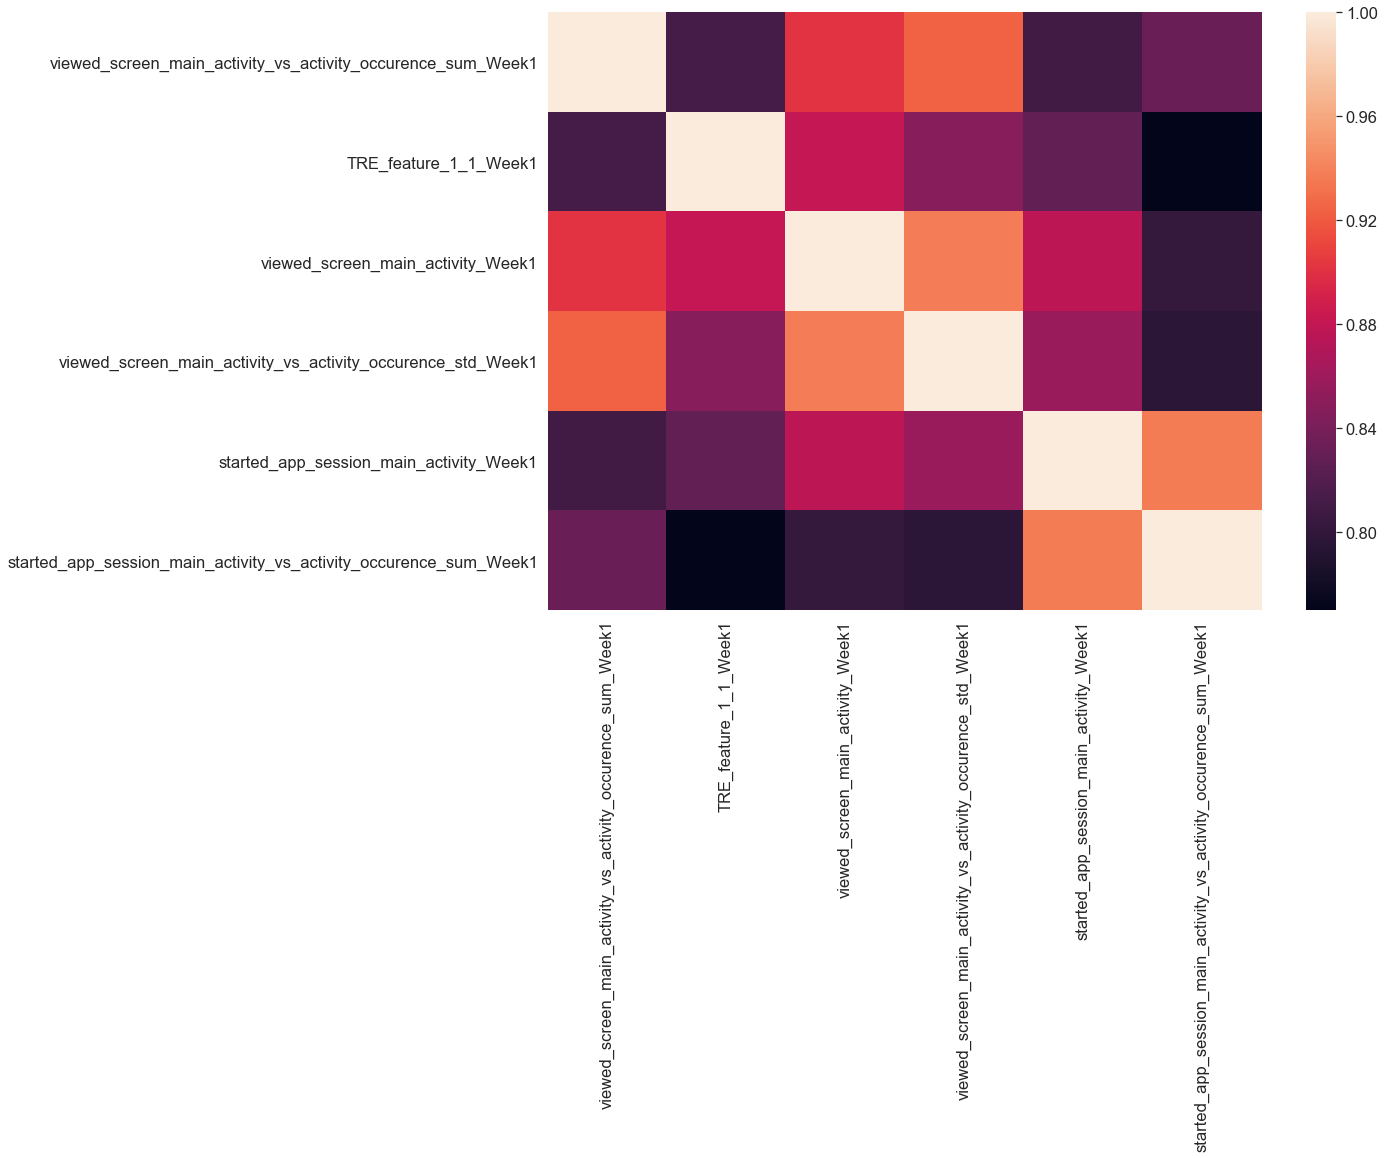

In [567]:
    
    
    corrmat = corr_df_num[col_0].corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(16,11)
    sns.heatmap(corrmat);

In [494]:
correlated_block

feature1                                           feature2      corr
19031  df_feature_3_1_notMissing  logged_daily_weight_main_activity_vs_activity_...  1.000000
19033  df_feature_3_1_notMissing  logged_daily_mindfulness_main_activity_vs_acti...  1.000000
19034  df_feature_3_1_notMissing  logged_daily_mindfulness_main_activity_vs_acti...  1.000000
19035  df_feature_3_1_notMissing                          df_feature_3_1_notMissing  1.000000
19036  df_feature_3_1_notMissing             pressed fast forward_feature_1_1_Week6  1.000000
27530  df_feature_3_1_notMissing  logged_daily_mindfulness_main_activity_vs_acti...  1.000000
27578  df_feature_3_1_notMissing       logged_daily_mindfulness_main_activity_Week8  1.000000
38818  df_feature_3_1_notMissing                          df_feature_2_1_notMissing  0.964274
39201  df_feature_3_1_notMissing                     Not-Misisng_feature_3_1_Month1  0.961951

## top 10 most important features and its relevant correlated features

In [410]:
x = pd.Series(models[i].feature_importances_, X_train.columns).sort_values(ascending=False)
x#.index

Missing_feature_1_1_Month1                                            39
df_feature_3_1_missing                                                29
feature_1_1_Week2_Total                                               28
main_activity_Weekday_count_Total.1                                   28
opened_app_main_activity_vs_activity_occurence_count                  28
Missing_feature_3_1_Week1                                             28
Other_main_activity_vs_activity_occurence_count                       24
Other_main_activity_vs_activity_occurence_std                         23
Not-Misisng_feature_3_1_Week1                                         22
main_activity_main_activity_vs_activity_occurence_sum_Month_Total1    21
Feature_3_nunique                                                     21
viewed_screen_main_activity_vs_activity_occurence_count               20
error_feature_1_1_Month1                                              20
Other_main_activity_vs_activity_occurence_std_Month

In [301]:
X_traiaaan.shape

(387, 40)

In [302]:
x = pd.Series(lgb_optimized.feature_importances_, X_train.columns).sort_values(ascending=True)
x

ValueError: Length of passed values is 13, index implies 40

In [288]:
cols = list(x.index) #= x[x>10] 


In [331]:
# plot importance
import lightgbm

def feature_importance(model,columns):
    # Plot importance for beset model: model_mse
    fig, ax = plt.subplots(figsize=(18,12))

    g1 = lightgbm.plot_importance(model,ax=ax,grid=False)

    oldy = g1.yaxis.get_majorticklabels()
    feature_dict = dict(zip(['Column_'+str(i) for i in range(len(columns))], columns))
    newy = [feature_dict[y._text] for y in oldy]
    g1.set_yticklabels(newy,rotation=0,fontsize=18)

    #fig.savefig('feature_importance.jpg')
    #plt.title('Feature Importance',fontsize=26)
    plt.xlabel('Feature importance',fontsize = 24)
    plt.ylabel('Features', fontsize = 24)
    plt.show()

KeyError: 'feature_1_1_Week2_Total'

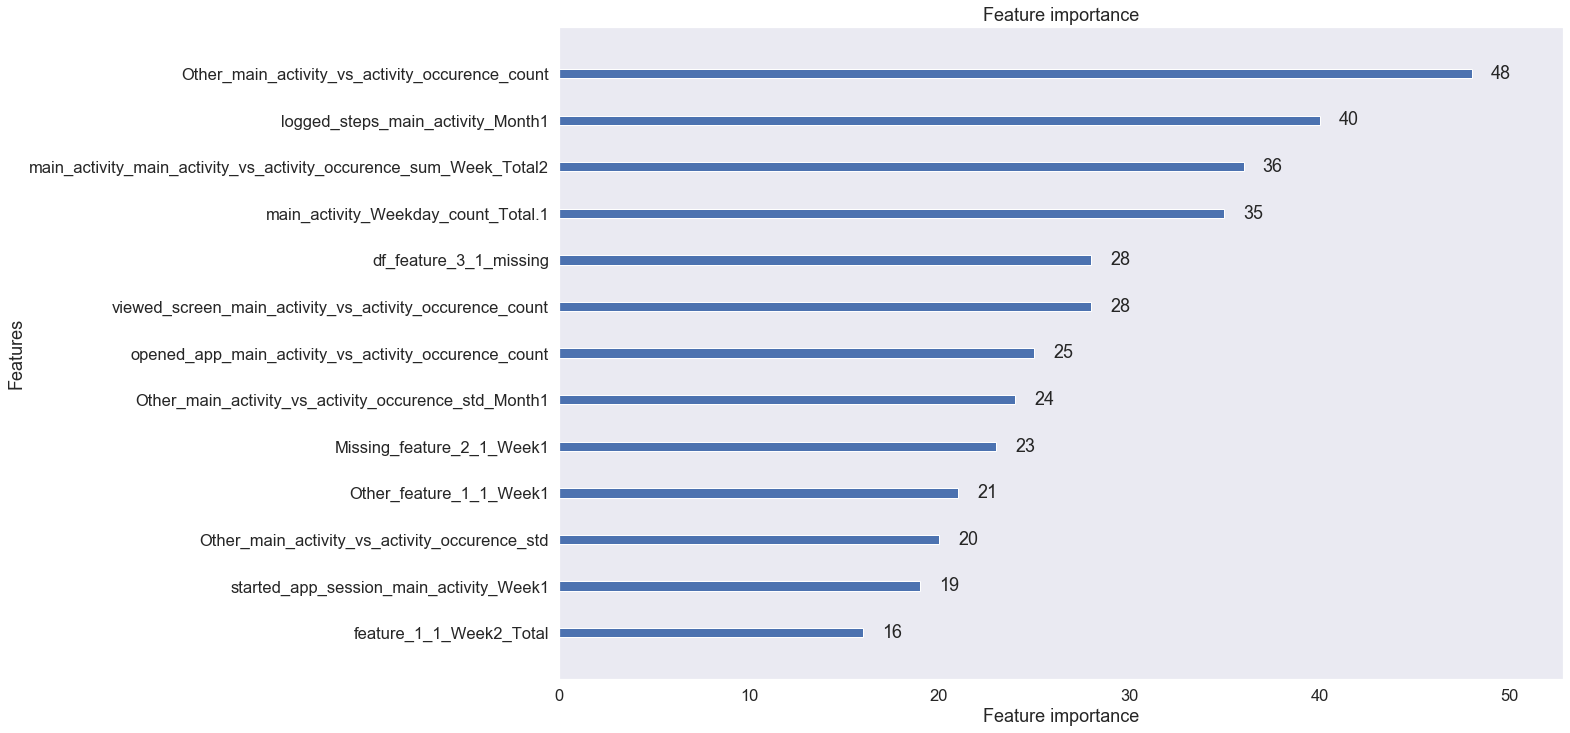

In [332]:
feature_importance(lgb_optimized,X_train.columns)


In [292]:
X_test[cols]

started_app_session_main_activity_Week1  Other_main_activity_vs_activity_occurence_std  Missing_feature_2_1_Week1  opened_app_main_activity_vs_activity_occurence_count  viewed_screen_main_activity_vs_activity_occurence_count  Other_feature_1_1_Week1  main_activity_main_activity_vs_activity_occurence_sum_Week_Total2  df_feature_3_1_missing  Other_main_activity_vs_activity_occurence_std_Month1  logged_steps_main_activity_Month1  main_activity_Weekday_count_Total.1  Other_main_activity_vs_activity_occurence_count  feature_1_1_Week2_Total
85                                 -0.537921                                       1.251995                   0.549215                                           0.857833                                              0.296142                      -0.309708                                           0.986671                                0.595616                                           1.573952                              0.213652                             0.393845                                         1.335523                 1.621000
132                                 1.261367                                       2.181303                   1.882261                                           0.368772                                              0.765496                       1.069205                                          -0.914635                                0.600463                                           2.609617                             -1.171268                            -0.975426                                         1.713452                -0.949718
96                                  1.414239                                       0.121638                   1.232695                                           0.240710                                              0.623499                       1.239736                                          -0.914635                                0.895935                                           0.314227                             -0.116342                             0.496989                                         0.712554                -0.949718
107                                 0.651344                                       0.535472                   1.008632                                           0.864567                                              0.827066                       0.554151                                           1.464255                                1.419955                                           0.775424                              1.123594                             1.140761                                         0.896614                 1.806841
140                                 0.361723                                       0.268410                   0.549215                                           1.601950                                              0.253243                       0.298234                                           1.444040                                1.395510                                           0.477797                              1.110986                             1.187462                                         0.827444                 1.784383
37                                 -1.437565                                      -0.885338                  -1.712641                                          -1.590210                                             -1.708672                      -1.595307                                          -0.914635                               -1.759242                                          -0.807995                             -0.886186                            -1.759692                                        -2.065534                -0.949718
501                                -0.011663                                       0.502372                   0.024179                                           1.826604              

In [294]:
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=9)



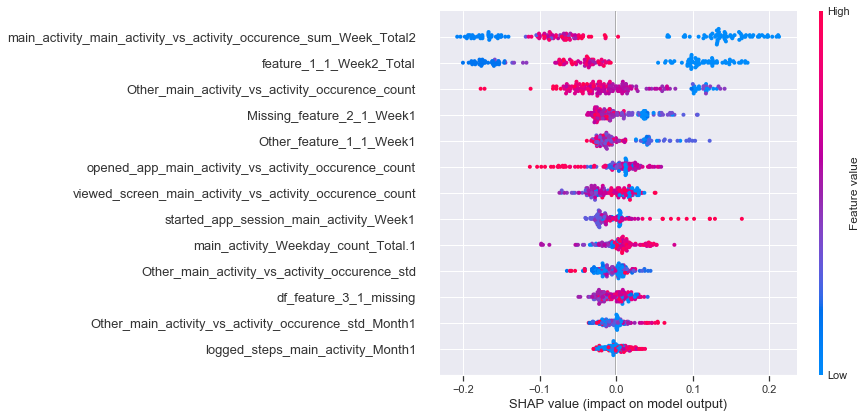

In [295]:
import shap  

#rfc = RandomForestClassifier()
rf.fit(X_train[cols],y_train)
# Create object that will calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test[cols]) 
# Summary plot
shap.summary_plot(shap_values[1], X_test[cols])

In [232]:
x = pd.Series(models[i].feature_importances_, X_train.columns).sort_values(ascending=True)
x[x>10]                                                            

started_app_session_main_activity_Week1                              11
Other_main_activity_vs_activity_occurence_std                        11
Missing_feature_2_1_Week1                                            11
opened_app_main_activity_vs_activity_occurence_count                 12
viewed_screen_main_activity_vs_activity_occurence_count              13
Other_feature_1_1_Week1                                              13
main_activity_main_activity_vs_activity_occurence_sum_Week_Total2    13
df_feature_3_1_missing                                               13
Other_main_activity_vs_activity_occurence_std_Month1                 17
logged_steps_main_activity_Month1                                    19
main_activity_Weekday_count_Total.1                                  20
Other_main_activity_vs_activity_occurence_count                      25
feature_1_1_Week2_Total                                              30
dtype: int32

In [123]:
# Models
logreg = LogisticRegression(random_state=0) 
randomforest = RandomForestClassifier(random_state=0, class_weight="balanced") 
gbk = GradientBoostingClassifier(random_state=0) 
xgb = XGBClassifier()
lgb = LGBMClassifier(boosting_type='gbdt',class_weight='balanced')

# Splititng data into train and test set
df_x = df_log[selected_feat]
X = df_x
y = df2['subscription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

index = X_train.index
cols = X_train.columns
index1 = X_test.index
cols1 = X_test.columns
# Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train, index=index, columns=cols)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test, index=index1, columns=cols1)

In [124]:
X_train.shape

(387, 5)

In [125]:
selected_feat

Index(['main_activity_Weekday_count_Total.1', 'feature_1_1_Week2_Total', 'Feature_3_nunique', 'df_feature_3_1_missing', 'Other_main_activity_vs_activity_occurence_count'], dtype='object')

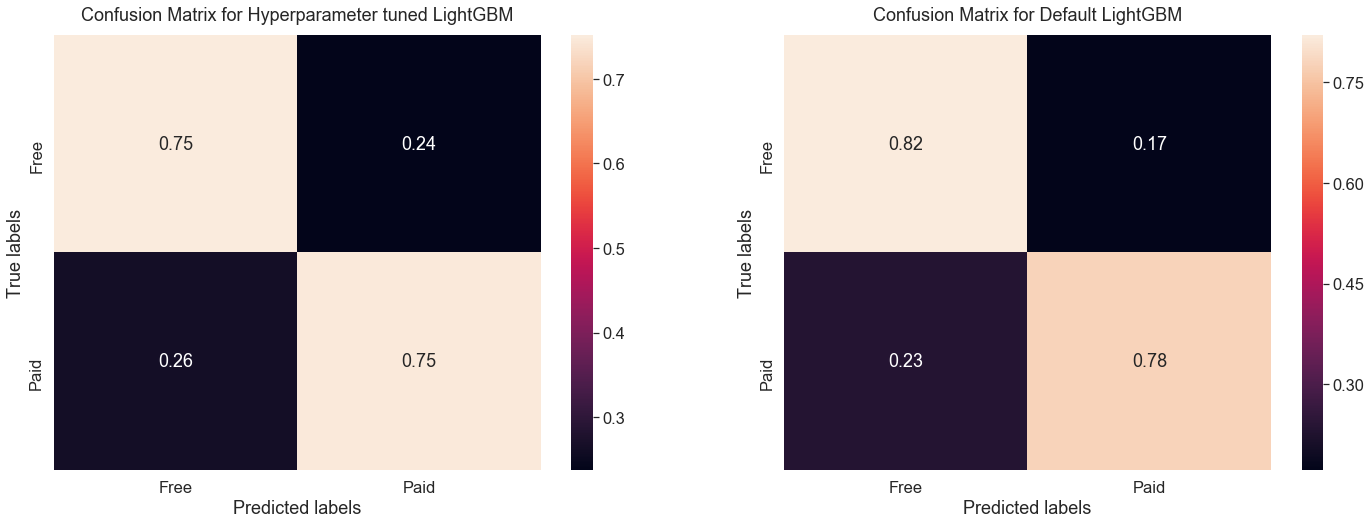

In [126]:
lgb_optimized2 = LGBMClassifier(bagging_freq=2,colsample_bytree=0.55,learning_rate=0.95, loss='deviance', max_depth=10,
                     max_features='auto',min_samples_split=1,n_estimators=40, n_jobs=-1,random_state=0,
                     subsample=0.95, subsample_for_bin=300000)

#(bagging_freq=8,colsample_bytree=0.9,learning_rate=0.175, loss='deviance', max_depth=6,
                 #    max_features='auto',min_samples_split=2,n_estimators=35, n_jobs=-1,random_state=0,
                 #    subsample=0.9, subsample_for_bin=150000)\\
lgb_default2 = LGBMClassifier(random_state=0)

models = [lgb_optimized2, lgb_default2]
model_names = ['Hyperparameter tuned LightGBM', 'Default LightGBM']

from sklearn.metrics import confusion_matrix
def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        y_pred = cross_val_predict(models[i], X, y, cv=kfold)
        #labels = ['Free-Tier', 'Paid-Subscriber']
        C = confusion_matrix(y,y_pred)
        C = C / C.astype(np.float).sum(axis=1)
        sns.heatmap(C,ax=ax[i],annot=True)
        #confusion_matrix(y,y_pred)
        ax[i].set_title('Confusion Matrix for '+ model_names[i], pad=15) 
        # labels, title and ticks
        ax[i].set_xlabel('Predicted labels');ax[i].set_ylabel('True labels');  
        ax[i].xaxis.set_ticklabels(['Free', 'Paid']); ax[i].yaxis.set_ticklabels(['Free', 'Paid']);
        
fig, ax = plt.subplots(1,2,figsize=(24,8))
confusion_matrix_plot(X_train, y_train)

In [257]:
X_train.columns

Index(['Missing_source_Month1', 'Missing_source_Week1', 'Other_main_activity_Month1', 'logged_steps_main_activity_Month1', 'logged_in_main_activity_Week1', 'opened_app_main_activity_Week1', 'started_app_session_main_activity_Week1', 'main_activity_Weekday_count_Total.1', 'Feature1_1_count_nUnique', 'Missing_feature_1_1_Month1', 'error_feature_1_1_Month1', 'Other_feature_1_1_Week1', 'TRE_feature_1_1_Week1', 'feature_1_1_Week2_Total', 'Feature_2_nunique', 'df_feature_2_1_missing', 'Missing_feature_2_1_Week1', 'Feature_3_nunique', 'df_feature_3_1_missing', 'df_feature_3_1_notMissing', 'Missing_feature_3_1_Month1', 'Not-Misisng_feature_3_1_Month1', 'Missing_feature_3_1_Week1', 'Not-Misisng_feature_3_1_Week1', 'Other_main_activity_vs_activity_occurence_count', 'logged_steps_main_activity_vs_activity_occurence_count', 'opened_app_main_activity_vs_activity_occurence_count', 'received_error_main_activity_vs_activity_occurence_count', 'viewed_screen_main_activity_vs_activity_occurence_count',
 

In [265]:
def featureComboTest(top_feats):
    # run minimal model using combinations of top features and determine minimal features required for excellence.
    # define labels (y) and features (X)
   # y = feats['Class'].values
   # X = feats[top_feats].values

    # call SMOTE, use defauls first
    #sm = SMOTE(random_state=42)
   # X_res, y_res = sm.fit_resample(X, y)

    # labelEncode SMOTE
    #le = LabelEncoder()
    #y_res_le = le.fit_transform(y_res)

    # fit model
    clf = lgb_optimized2  # use defaults

    # calculate CV score for AUC
    return cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')#.mean()

In [266]:
feature_set = X_train.columns
len(feature_set)

40

In [267]:
# define func to return possible combinations of features
from itertools import combinations
from tqdm import tqdm_notebook

def rSubset(arr, r):

    # return list of all subsets of length r
    # to deal with duplicate subsets use set(list(combinations(arr, r)))
    return list(combinations(arr, r))

top_feats = ['main_activity_main_activity_vs_activity_occurence_sum_Month_Total1', 
             'Other_main_activity_vs_activity_occurence_std_Month1', 
             'main_activity_main_activity_vs_activity_occurence_sum_Week_Total2', 
             'Avg_Weekend_Count_Total']
num_feats = np.arange(len(feature_set))
feat_scores = {}
for i in tqdm_notebook(num_feats):
    feature_set = rSubset(top_feats, i)
    for j in tqdm_notebook(range(len(feature_set))):
        feat_scores[' + '.join(list(feature_set[j]))
                    ] = featureComboTest(list(feature_set[j]))

In [268]:
# cast to df, then melt for plotting
df_scores = pd.melt(pd.DataFrame(feat_scores),
                    var_name='features', value_name='AUC')
# make boxplot
plt.subplots(figsize=(120, 120))
sns.boxplot(y='features', x='AUC', data=df_scores);

In [269]:
df_scores.groupby('features').agg(['mean','std']).sort_values(('AUC', 'mean'), ascending=False)

AUC          
                                                        mean       std
features                                                              
                                                    0.894138  0.047283
Avg_Weekend_Count_Total                             0.894138  0.047283
Other_main_activity_vs_activity_occurence_std_M...  0.894138  0.047283
Other_main_activity_vs_activity_occurence_std_M...  0.894138  0.047283
Other_main_activity_vs_activity_occurence_std_M...  0.894138  0.047283
Other_main_activity_vs_activity_occurence_std_M...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283
main_activity_main_activity_vs_activity_occuren...  0.894138  0.047283

In [67]:
col

Index(['Missing_source_Month1', 'Other_main_activity_Month1', 'logged_steps_main_activity_Month1', 'logged_in_main_activity_Week1', 'opened_app_main_activity_Week1', 'started_app_session_main_activity_Week1', 'main_activity_Weekday_count_Total.1', 'Missing_feature_1_1_Month1', 'error_feature_1_1_Month1', 'Other_feature_1_1_Week1', 'feature_1_1_Week2_Total', 'Feature_2_nunique', 'df_feature_2_1_missing', 'Missing_feature_2_1_Week1', 'Feature_3_nunique', 'df_feature_3_1_missing', 'df_feature_3_1_notMissing', 'Not-Misisng_feature_3_1_Month1', 'Missing_feature_3_1_Week1', 'Not-Misisng_feature_3_1_Week1', 'Other_main_activity_vs_activity_occurence_count', 'opened_app_main_activity_vs_activity_occurence_count', 'viewed_screen_main_activity_vs_activity_occurence_count', 'viewed_session_element_main_activity_vs_activity_occurence_count', 'Other_main_activity_vs_activity_occurence_sum', 'logged_steps_main_activity_vs_activity_occurence_sum', 'Other_main_activity_vs_activity_occurence_std',
    

In [66]:
len(col)

30

In [91]:
col = X_train.columns
X_train2 = X_train.drop(columns=['feature_1_1_Week2_Total','Other_main_activity_vs_activity_occurence_count','main_activity_main_activity_vs_activity_occurence_sum_Week_Total2','Other_main_activity_vs_activity_occurence_sum','Other_main_activity_Month1'])
X_test2 = X_test.drop(columns=['feature_1_1_Week2_Total','Other_main_activity_vs_activity_occurence_count','main_activity_main_activity_vs_activity_occurence_sum_Week_Total2','Other_main_activity_vs_activity_occurence_sum','Other_main_activity_Month1'])

In [92]:
X_train2.shape, X_test2.shape

((387, 25), (166, 25))

# Might be SHAP wont be useful here

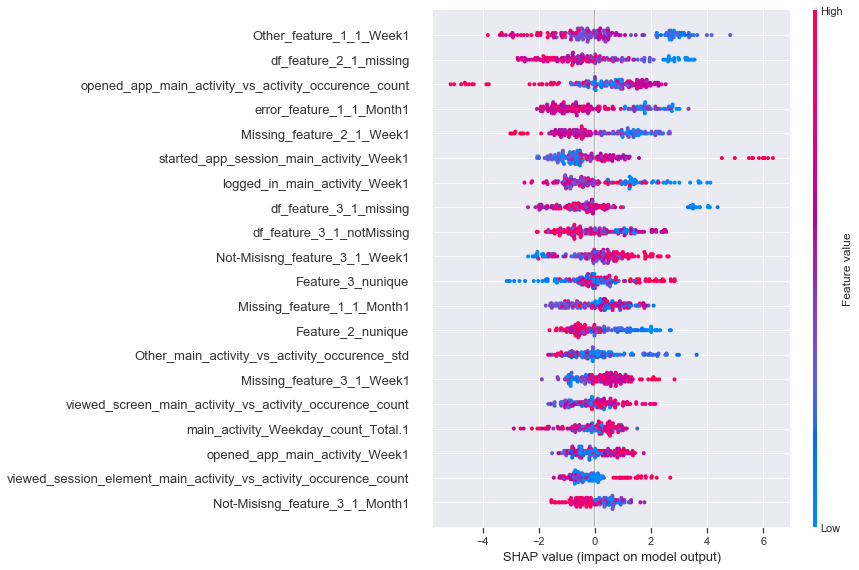

In [93]:
import shap  

#rfc = RandomForestClassifier()
lgb_optimized2.fit(X_train2,y_train)
# Create object that will calculate shap values
explainer = shap.TreeExplainer(lgb_optimized2)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test2) 
# Summary plot
shap.summary_plot(shap_values[1], X_test2)

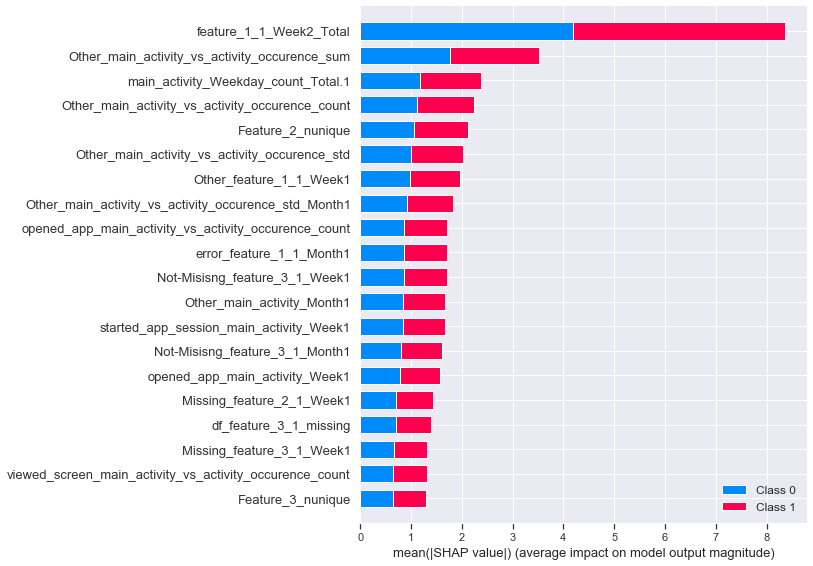

In [81]:
#rfc = RandomForestClassifier()
lgb_optimized2.fit(X_train,y_train)

import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(lgb_optimized2)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test) 
# Summary plot
shap.summary_plot(shap_values, X_test)

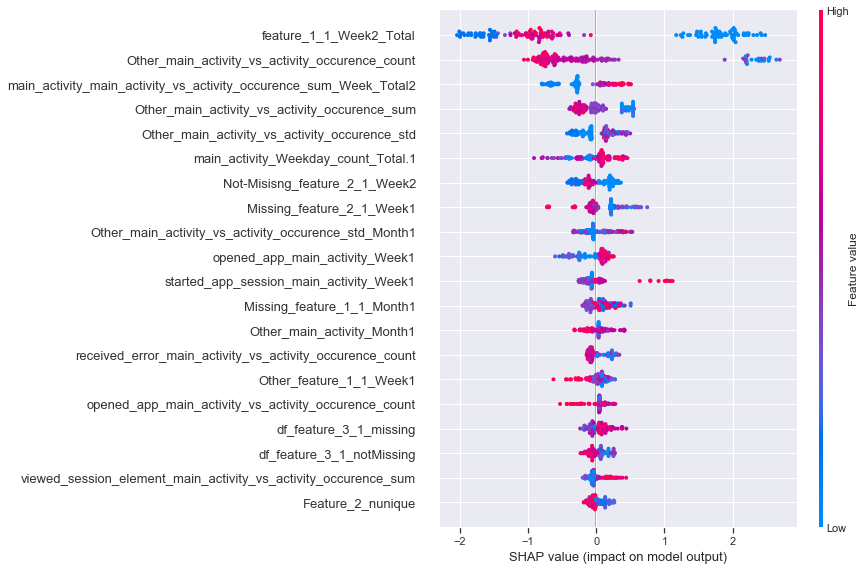

In [186]:
#rfc = RandomForestClassifier()
lgb_optimized.fit(X_train,y_train)

import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(lgb_optimized)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test) 
# Summary plot
shap.summary_plot(shap_values[1], X_test)

**Inference**

Hard to infer here, probably reduce feature space and then ran shap

In [204]:
def featureComboTest(top_feats):
    # run minimal model using combinations of top features and determine minimal features required for excellence.
    # define labels (y) and features (X)
   # y = feats['Class'].values
   # X = feats[top_feats].values

    # call SMOTE, use defauls first
    #sm = SMOTE(random_state=42)
   # X_res, y_res = sm.fit_resample(X, y)

    # labelEncode SMOTE
    #le = LabelEncoder()
    #y_res_le = le.fit_transform(y_res)

    # fit model
    clf = GradientBoostingClassifier(random_state=42)  # use defaults

    # calculate CV score for AUC
    return cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')

In [205]:
X_train.head(2)

Missing_source_Month1  Missing_source_Week1  Other_main_activity_Month1  identified_app_user_main_activity_Month1  logged_in_main_activity_Month1  logged_steps_main_activity_Month1  opened_app_main_activity_Month1  started_session_main_activity_Month1  viewed_screen_main_activity_Month1  main_activity_Month1_Total  Other_main_activity_Week1  identified_app_user_main_activity_Week1  logged_in_main_activity_Week1  logged_steps_main_activity_Week1  opened_app_main_activity_Week1  received_error_main_activity_Week1  started_app_session_main_activity_Week1  started_session_main_activity_Week1  viewed_screen_main_activity_Week1  main_activity_Week1_Total  main_activity_Weekday_count_Total  main_activity_Weekday_nunique_Total  main_activity_Weekday_count_Total.1  main_activity_Weekday_nunique_Total.1  Feature1_1_count_nUnique  Missing_feature_1_1_Month1  Other_feature_1_1_Month1  TRE_feature_1_1_Month1  error_feature_1_1_Month1  fitness-training_feature_1_1_Month1  \
313              -0.073876              0.029682                   -0.095993                                  0.418293                       -0.132604                          -1.171268                        -0.020863                               0.86664                            0.360904                   -0.202281                  -0.009732                                 0.732687                        0.15917                          -1.16367                        0.318177                            0.858907                                 0.651344                             1.105379                           0.562625                  -0.036454                           0.035008                             0.200805                            -2.151825                               -2.72269                  0.459309                   -0.460692                  0.336290                0.215929                  0.619361                             1.130640   
447              -0.596677             -0.483393                    0.014809                                 -0.446517                       -0.563199                          -1.171268                        -0.772334                               0.32604                            0.590598                   -0.657405                   0.127114                                -0.311827                       -0.35757                          -1.16367                       -0.598785                            0.435491                                -0.537921                             0.511191                           0.810710                  -0.498474                          -0.348661                             0.200805                            -2.151825                               -2.72269                 -0.091979                   -1.044032                  0.404493                0.111184                  0.232609                             0.855882   

     viewed_screen_feature_1_1_Month1  Other_feature_1_1_Week1  TRE_feature_1_1_Week1  fitness-training_feature_1_1_Week1  feature_1_1_Week2_Total  Feature_2_nunique  df_feature_2_1_missing  df_feature_2_1_notMissing  Missing_feature_2_1_Month1  Missing_feature_2_1_Week1  Not-Misisng_feature_2_1_Week2  Feature_3_count_Total  Feature_3_nunique  df_feature_3_1_missing  df_feature_3_1_notMissing  Missing_feature_3_1_Month1  Not-Misisng_feature_3_1_Month1  Missing_feature_3_1_Week1  Not-Misisng_feature_3_1_Week1  Other_main_activity_vs_activity_occurence_count  closed_session_main_activity_vs_activity_occurence_count  identified_app_user_main_activity_vs_activity_occurence_count  logged_in_main_activity_vs_activity_occurence_count  logged_steps_main_activity_vs_activity_occurence_count  opened_app_main_activity_vs_activity_occurence_count  received_error_main_activity_vs_activity_occurence_count  started_app_session_main_activity_vs_activity_occurence_count  \
313                          0.329039                 0.478554               0.515132        

In [206]:
feature_set = X_train.columns
feature_set

Index(['Missing_source_Month1', 'Missing_source_Week1', 'Other_main_activity_Month1', 'identified_app_user_main_activity_Month1', 'logged_in_main_activity_Month1', 'logged_steps_main_activity_Month1', 'opened_app_main_activity_Month1', 'started_session_main_activity_Month1', 'viewed_screen_main_activity_Month1', 'main_activity_Month1_Total',
       ...
       'Other_main_activity_vs_activity_occurence_std_Week1', 'opened_app_main_activity_vs_activity_occurence_std_Week1', 'received_error_main_activity_vs_activity_occurence_std_Week1', 'viewed_screen_main_activity_vs_activity_occurence_std_Week1', 'main_activity_main_activity_vs_activity_occurence_sum_Week_Total2', 'Avg_Weekend_Count_Total', 'shared_apple_data', 'kmeans_pred_0.0', 'kmeans_pred_1.0', 'kmeans_pred_Missing'], dtype='object', length=109)

In [207]:
len(feature_set)

109

In [208]:
np.arange(len(feature_set))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108])

In [209]:
# define func to return possible combinations of features
from itertools import combinations
from tqdm import tqdm_notebook


def rSubset(arr, r):

    # return list of all subsets of length r
    # to deal with duplicate subsets use
    # set(list(combinations(arr, r)))
    return list(combinations(arr, r))


top_feats = feature_set#['Clump Thickness', 'Uniformity of Cell Size',
             #'Bare Nuclei', 'Marginal Adhesion', 'Bland Chromatin']
num_feats = np.arange(len(feature_set))#[1, 2, 3, 4]
feat_scores = {}
for i in tqdm_notebook(num_feats):
    feature_set = rSubset(top_feats, i)
    for j in tqdm_notebook(range(len(feature_set))):
        feat_scores[' + '.join(list(feature_set[j]))
                    ] = featureComboTest(list(feature_set[j]))

KeyboardInterrupt: 

In [ ]:
[lgb_optimized, rf, xgb, lr]

In [ ]:
# Step backward elimination (LightGBM)

In [ ]:
# new model with less feature (LightGBM) - Hyperparameter tune, confusion matrix -roc curve
# SHAP values

In [ ]:
# SHAP VALUES # Permutation importance
# James minimum algorothm format

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

imba_pipeline = make_pipeline(SMOTE(random_state=42), GradientBoostingClassifier(random_state=0))
#cross_val_score(imba_pipeline, X_train, y_train, scoring='precision', cv=strati_kf)

parameters = {
    'n_estimators': range(10,80, 10),#[50, 100, 200],
    'max_depth': range(1,10),#[2, 3, 4, 5, 6, 8, 10, 12],
    'learning_rate':[0.04, 0.045, 0.05,0.055],
    'min_samples_split': range(2,7),#
    'loss': ['deviance', 'exponential'],
    "max_features":["auto"], #,"log2","sqrt"
}

new_params = {'gradientboostingclassifier__' + key: parameters[key] for key in parameters}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=strati_kf, scoring='precision', #precision
                        return_train_score=True, verbose=1, n_jobs=-1)
grid_imba.fit(X_train, y_train)
grid_imba.best_params_

In [ ]:
 {
        'type': 'LightGBM',
        'max_depth': hp.choice('max_depth2', range(1,15)),
        'max_features': hp.choice('max_features2', ['auto','np.sqrt', 'np.log']),
        'n_estimators': hp.choice('n_estimators2', range(10,500,20)),
        "min_samples_split": hp.choice('min_samples_split2', range(2,15)),
       # "min_samples_leaf": hp.choice('min_samples_leaf2', range(1,15)),
        'learning_rate': hp.choice('learning_rate', [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
        'bagging_freq': hp.choice('bagging_freq', range(1,15)),
        'subsample_for_bin': hp.choice('subsample_for_bin', [200000, 300000, 400000]),
        'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'subsample':hp.choice('subsample2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        #'bagging_fraction':hp.choice('bagging_fraction', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
         #"criterion": hp.choice('criterion',["friedman_mse",  "mae"]),
        #'scale': hp.choice('scale', [0, 1]),
        #'normalize': hp.choice('normalize', [0, 1])

In [354]:
#########################################################################################################################
from sklearn.model_selection import GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#X1_stndz = sc.fit_transform(X1)
leaf = np.arange(1, 10,2)
depths = np.arange(1, 10,2)
splits = np.arange(2, 10,2)
n_estimators=range(50,400,50)
hyper={'max_depth': depths, 
       'min_samples_split': splits,
       'min_samples_leaf': leaf,
       'n_estimators':n_estimators,
       }
gd_RFC = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=hyper, 
                cv=kfold, scoring="precision", n_jobs= -1, verbose=True)
gd_RFC.fit(X_train,y_train)
print(gd_RFC.best_score_)
print(gd_RFC.best_estimator_)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.8min


0.8658155496660788
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [357]:
rfc = gd_RFC.best_estimator_
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [362]:
rfc=RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [363]:
#y_pred = gd_RFC.best_estimator_.predict(X_test) # No columns removed
print(f'AUC OF THE HYPERTUNED MODEL: {roc_auc_score(y_test, y_pred)}')
print(f'ACCURACY OF THE HYPERTUNED MODEL: {rfc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

AUC OF THE HYPERTUNED MODEL: 0.8204678362573099
ACCURACY OF THE HYPERTUNED MODEL: 0.8253012048192772
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        90
           1       0.84      0.76      0.80        76

    accuracy                           0.83       166
   macro avg       0.83      0.82      0.82       166
weighted avg       0.83      0.83      0.82       166



IndexError: index 2 is out of bounds for axis 0 with size 2

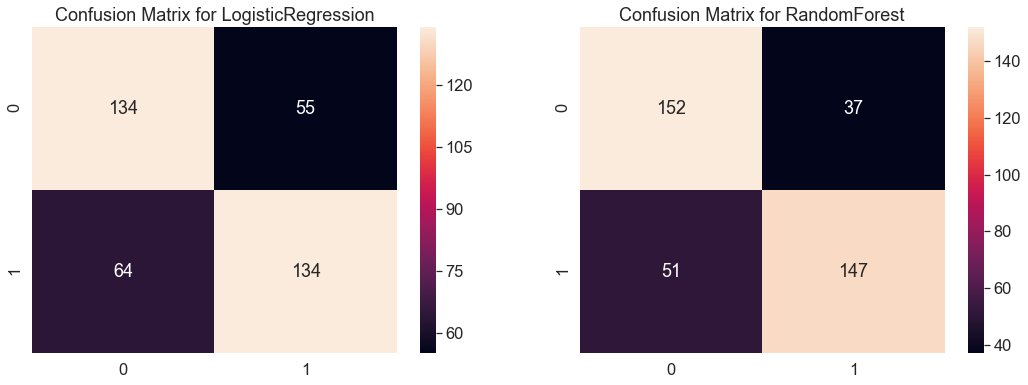

In [359]:
# Selected features
#cols = ['HR_Other.1', 'Total_activity_weekday', 'Total_Activity_Friday','Total_Activity_Saturday', 
#        'count_month', 'userwise_total_activities']
# Let's pick minimum and intuitive features and see how model performs 
#df1 = df[cols]
#X = df1
#y = df['kmeans_pred']

def confusion_matrix_plot(X, y):
    for i in range(len(models)):
        y_pred = cross_val_predict(models[i], X, y, cv=kfold)
        sns.heatmap(confusion_matrix(y,y_pred),ax=ax[i],annot=True,fmt='2.0f')
        ax[i].set_title('Confusion Matrix for '+ model_names[i]) 
        
fig, ax = plt.subplots(1,2,figsize=(18,6))
confusion_matrix_plot(X_train, y_train)

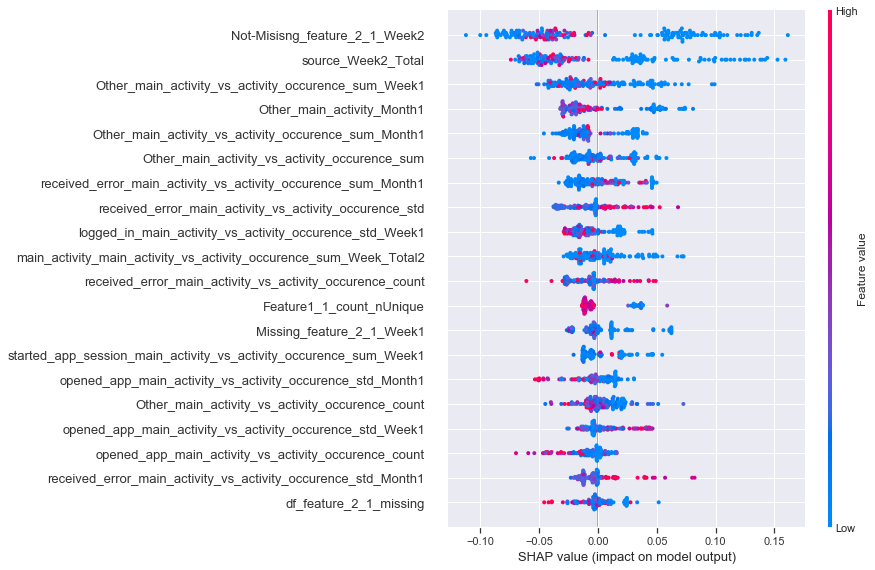

In [360]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(rfc)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test) 
# Summary plot
shap.summary_plot(shap_values[1], X_test)

In [361]:
#y_pred = gd_RFC.best_estimator_.predict(X_test) # columns removed with 50% missing values
print(f'AUC OF THE HYPERTUNED MODEL: {roc_auc_score(y_test, y_pred)}')
print(f'ACCURACY OF THE HYPERTUNED MODEL: {rfc.score(X_test, y_test)}')
print(classification_report(y_test, y_pred))

AUC OF THE HYPERTUNED MODEL: 0.6747076023391811
ACCURACY OF THE HYPERTUNED MODEL: 0.8012048192771084
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        90
           1       0.78      0.46      0.58        76

    accuracy                           0.69       166
   macro avg       0.72      0.67      0.67       166
weighted avg       0.71      0.69      0.68       166



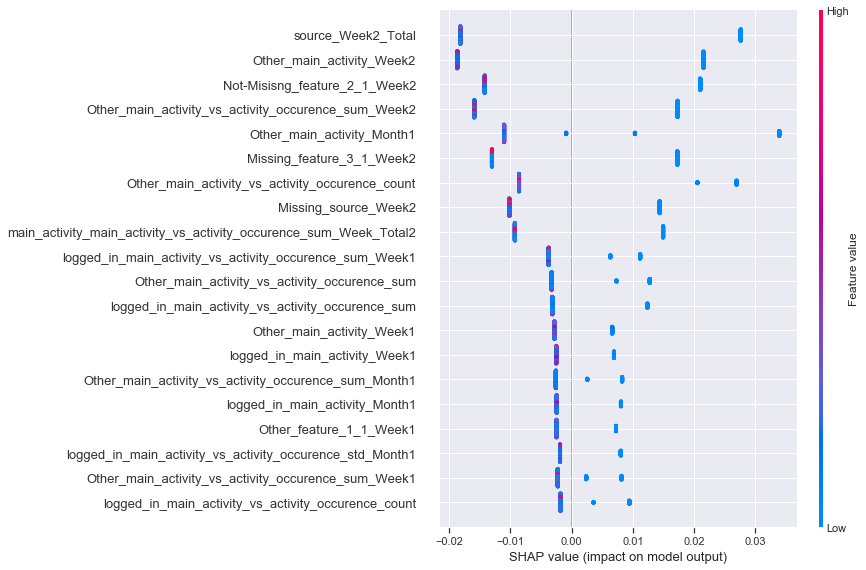

In [118]:
import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(gd_RFC.best_estimator_)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_train) 
# Summary plot
shap.summary_plot(shap_values[1], X_train)

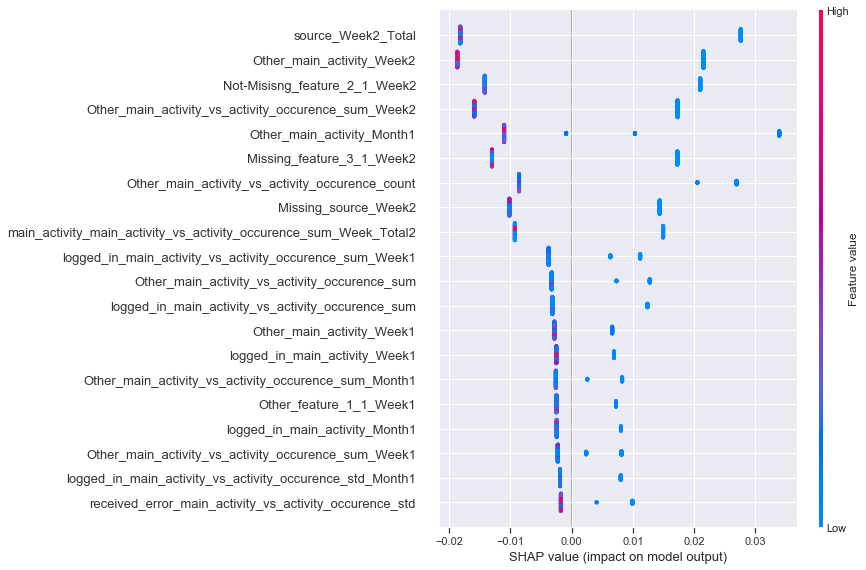

In [113]:
import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(rfc)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test) 
# Summary plot
shap.summary_plot(shap_values[1], X_test)

In [117]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfc, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [145]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [148]:
rfc = gd_RFC.best_estimator_

In [151]:
# step forward feature selection
# I indicate that I want to select 10 features from
# the total, and that I want to select those features
# based on the optimal roc_auc

sfs_bal = SFS(RandomForestClassifier(n_jobs=4), # n_jobs is no. of processor in computer
           k_features=20, # no. of features we want to select
           forward=True, # Step forward selection
           floating=False, 
           verbose=1,# outputs the result which helps to undersatnd at what feature t doesnt improve any mor
           scoring='roc_auc',
           cv=3)

sfs_bal = sfs_bal.fit(np.array(X_train), y_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 817 out of 817 | elapsed: 28.9min finished
Features: 1/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 816 out of 816 | elapsed:  8.0min finished
Features: 2/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 815 out of 815 | elapsed:  8.1min finished
Features: 3/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 814 out of 814 | elapsed:  8.1min finished
Features: 4/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 813 out of 813 | elapsed:  8.1min finished
Features: 5/20[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 812 out of 812 | elapsed:  8.1min finished
Features: 6/20[Parallel(

In [153]:
# Features after balancing dataset
sfs_bal = X_train.columns[list(sfs_bal.k_feature_idx_)]
sfs_bal

Index(['segment_ios_source_Week6', 'started_session_main_activity_Week6', 'pressed_next_main_activity_Week8', 'Feature1_1_count_nUnique', 'watch_feature_1_1_Week5', 'other_feature_1_1_Week6', 'Other_feature_1_1_Week8', 'Missing_feature_2_1_Week1', 'Missing_feature_2_1_Week7', 'Missing_feature_3_1_Week2', 'Other_main_activity_vs_activity_occurence_count', 'started_app_session_main_activity_vs_activity_occurence_std', 'Other_main_activity_vs_activity_occurence_std_Month1', 'started_app_session_main_activity_vs_activity_occurence_sum_Week1', 'completed_session_main_activity_vs_activity_occurence_sum_Week3', 'started_session_main_activity_vs_activity_occurence_std_Week3', 'main_activity_main_activity_vs_activity_occurence_std_Week_Total3', 'logged_daily_sleep_main_activity_vs_activity_occurence_sum_Week6', 'interacted_with_media_main_activity_vs_activity_occurence_std_Week6', 'completed_session_main_activity_vs_activity_occurence_sum_Week7'], dtype='object')

In [195]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=9)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    pred2 = rf.predict(X_test)
    print(f'AUC OF THE HYPERTUNED MODEL: {roc_auc_score(y_test, pred2)}')
    print(classification_report(y_test, pred2))

# evaluate performance of algorithm built
# using selected features
run_randomForests(X_train[sfs_bal],
                  X_test[sfs_bal],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.999438832772166
Test set
Random Forests roc-auc: 0.9207602339181287
AUC OF THE HYPERTUNED MODEL: 0.8366959064327486
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        90
           1       0.82      0.83      0.82        76

    accuracy                           0.84       166
   macro avg       0.84      0.84      0.84       166
weighted avg       0.84      0.84      0.84       166



In [ ]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

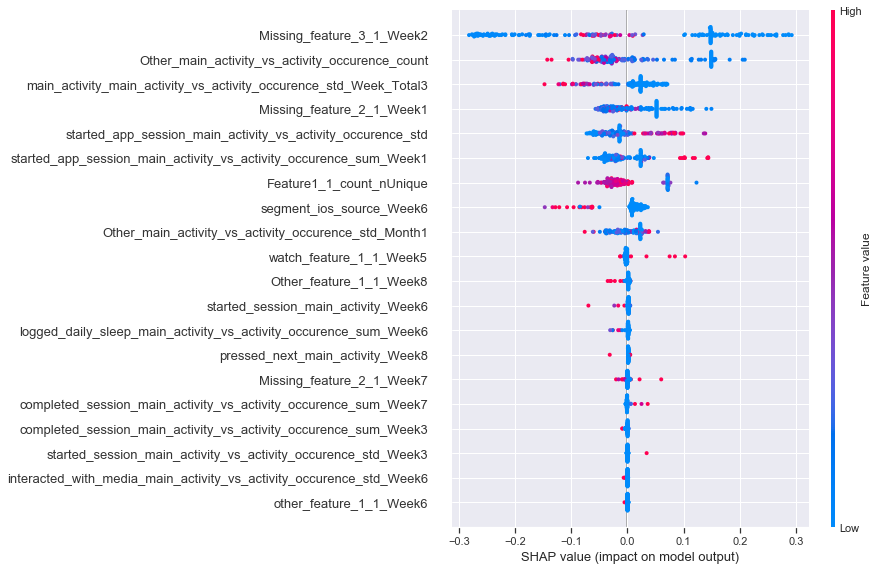

In [196]:
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=9)
rf.fit(X_train[sfs_bal], y_train)

import shap  
# Create object that will calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate shap_values for all of X_test1 rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test[sfs_bal]) 
# Summary plot
shap.summary_plot(shap_values[1], X_test[sfs_bal])

In [157]:
y_test.shape, y_train.shape

((166,), (387,))

In [163]:
cols = ['started_app_session_main_activity_vs_activity_occurence_sum_Week1', 
        'completed_session_main_activity_vs_activity_occurence_sum_Week3', 'started_session_main_activity_vs_activity_occurence_std_Week3', 
        'main_activity_main_activity_vs_activity_occurence_std_Week_Total3', 'logged_daily_sleep_main_activity_vs_activity_occurence_sum_Week6', 
        'interacted_with_media_main_activity_vs_activity_occurence_std_Week6', 'completed_session_main_activity_vs_activity_occurence_sum_Week7']

In [164]:
# evaluate performance of algorithm built
# using selected features
run_randomForests(X_train[cols],
                  X_test[cols],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8187296242851799
Test set
Random Forests roc-auc: 0.7258040935672515
AUC OF THE HYPERTUNED MODEL: 0.7045321637426902
              precision    recall  f1-score   support

           0       0.68      0.92      0.78        90
           1       0.84      0.49      0.62        76

    accuracy                           0.72       166
   macro avg       0.76      0.70      0.70       166
weighted avg       0.75      0.72      0.71       166

